# Cocktail Recommender System

## Importing Libraries

In [1]:
# !pip install scikit-surprise
# !pip install matplotlib seaborn
# !pip install --upgrade pandas numpy
# !pip install python-pptx
# !pip install sdv

In [2]:
# import sdv
# print(sdv.version.public)

In [3]:
# url = "https://dachang.github.io/CocktailViz/cocktailWheel.JSON"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import PredefinedKFold
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.stats import randint

## Loading the Dataset

In [5]:
# Load the dataset
cocktails_file_path = 'spreadsheets/cocktails.csv'
cocktails_df = pd.read_csv(cocktails_file_path)

# Replace all cells with '-' with blank
cocktails_df.replace('-', None, inplace=True)

# Display the first few rows of the updated dataset
print(cocktails_df.columns)
print(cocktails_df.shape)
cocktails_df.head()

Index(['Alcohol', 'Name', 'Category', 'Making', 'Base Wine',
       'Base Wine Amount', 'Liquor', 'Liquor Amount', 'Juice', 'Juice Amount',
       'Spice', 'Spice Amount', 'Soda', 'Soda Amount', 'Others', 'Taste',
       'Type of Glass', 'Salty', 'Savory', 'Sour', 'Bitter', 'Sweet', 'Spicy'],
      dtype='object')
(48, 23)


,Alcohol,Name,Category,Making,Base Wine,Base Wine Amount,Liquor,Liquor Amount,Juice,Juice Amount,...,Soda Amount,Others,Taste,Type of Glass,Salty,Savory,Sour,Bitter,Sweet,Spicy
0,5,Tequila Sunset,Short,Blend,Tequila,30,None,None,Lemon,30,...,None,Ice,Mild,Champagne Saucer,0,17,83,17,50,0
1,7,Chi-Chi,Long,Shake,Vodka,30,None,None,Pineapple,80,...,None,Coconut Milk,Mild,Armagnac Glasss,0,17,67,0,50,0
2,10,Sex on the Beach,Long,Build,Vodka,15,Melon_20/Raspberry_10,30,Pineapple,80,...,None,None,Mild,Highball,0,0,83,0,50,0
3,10,Horse’s Neck,Long,Build,Brandy,45,None,None,None,None,...,200,Lemon Piece,Mild,Old Fashioned,17,17,83,0,17,0
4,11,EL Diablo,Long,Build,Tequila,30,None,None,None,None,...,250,Orange Piece,Mild,Highball,17,0,50,17,50,0


## Exploratory Data Analysis

Cocktails Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Alcohol           48 non-null     int64 
 1   Name              48 non-null     object
 2   Category          48 non-null     object
 3   Making            48 non-null     object
 4   Base Wine         48 non-null     object
 5   Base Wine Amount  48 non-null     int64 
 6   Liquor            28 non-null     object
 7   Liquor Amount     27 non-null     object
 8   Juice             28 non-null     object
 9   Juice Amount      28 non-null     object
 10  Spice             17 non-null     object
 11  Spice Amount      17 non-null     object
 12  Soda              12 non-null     object
 13  Soda Amount       12 non-null     object
 14  Others            28 non-null     object
 15  Taste             48 non-null     object
 16  Type of Glass     48 non-null     object
 1

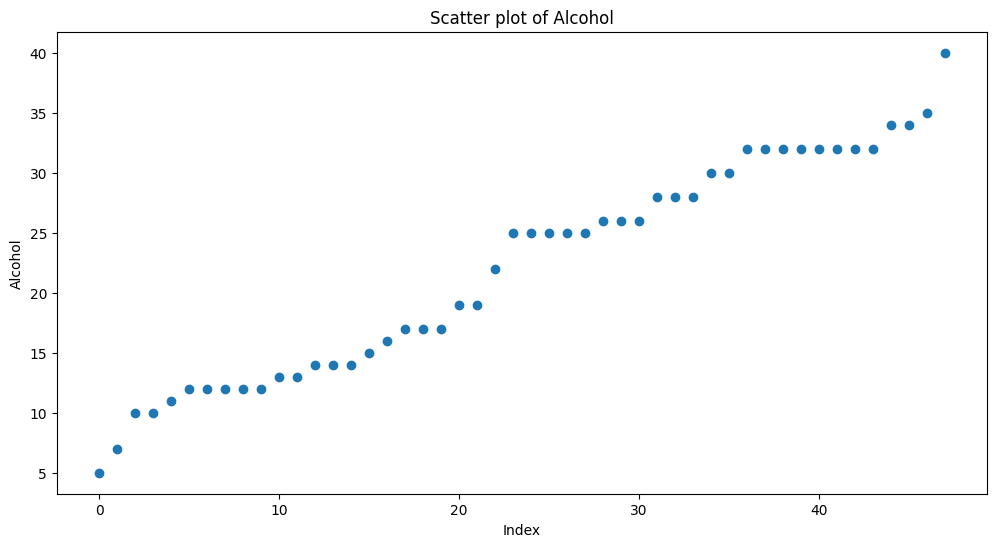

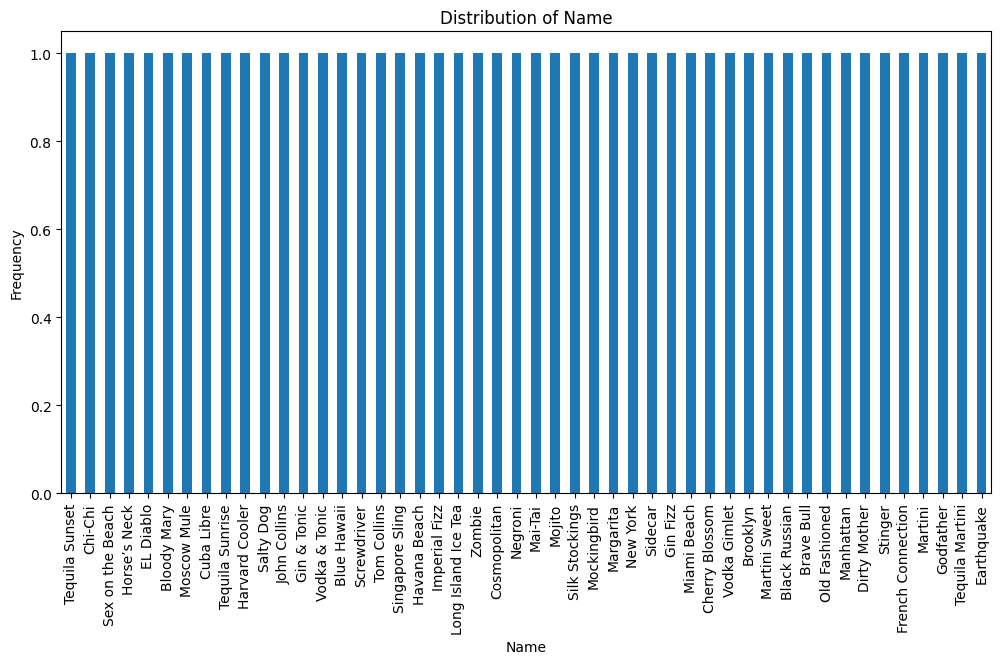

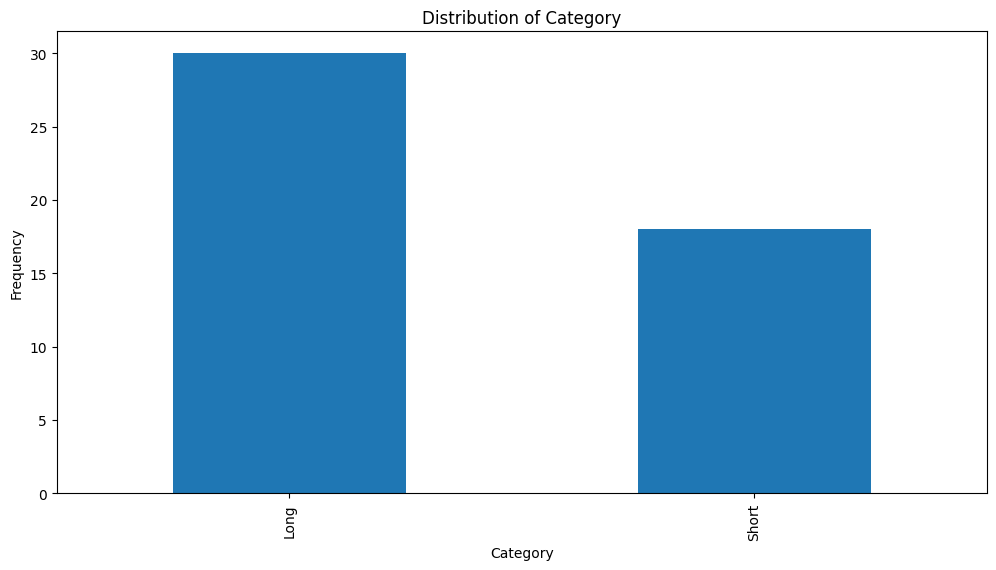

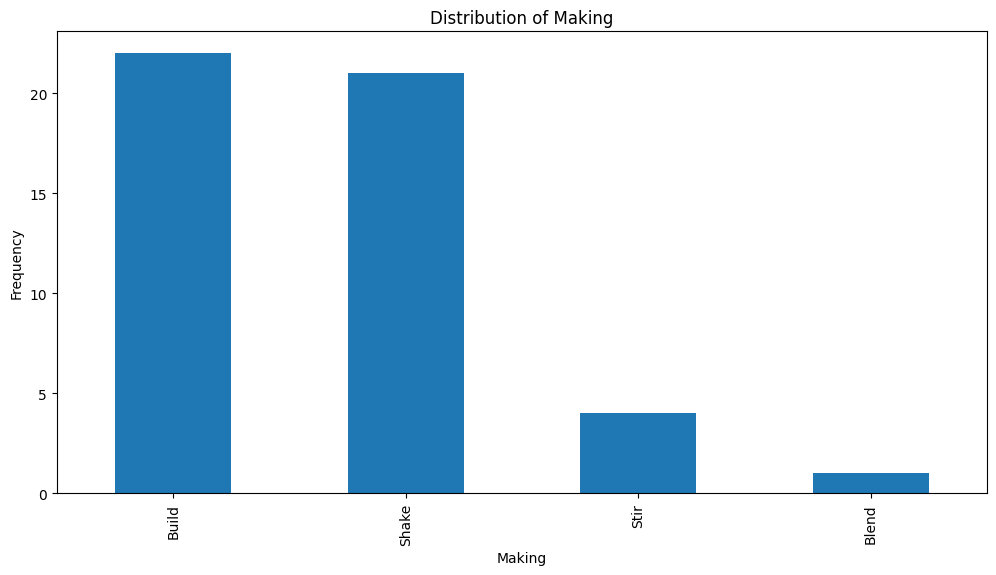

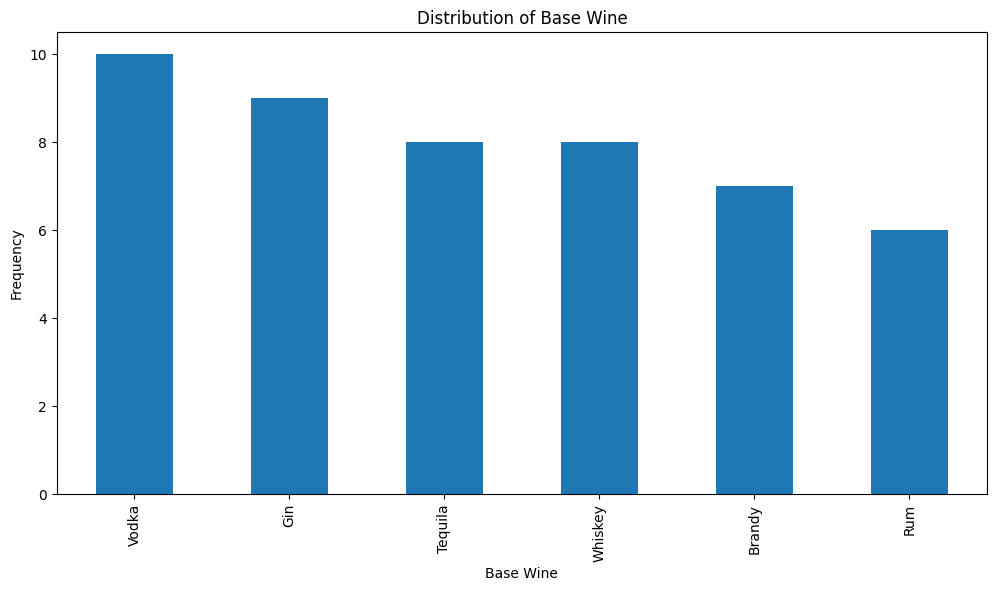

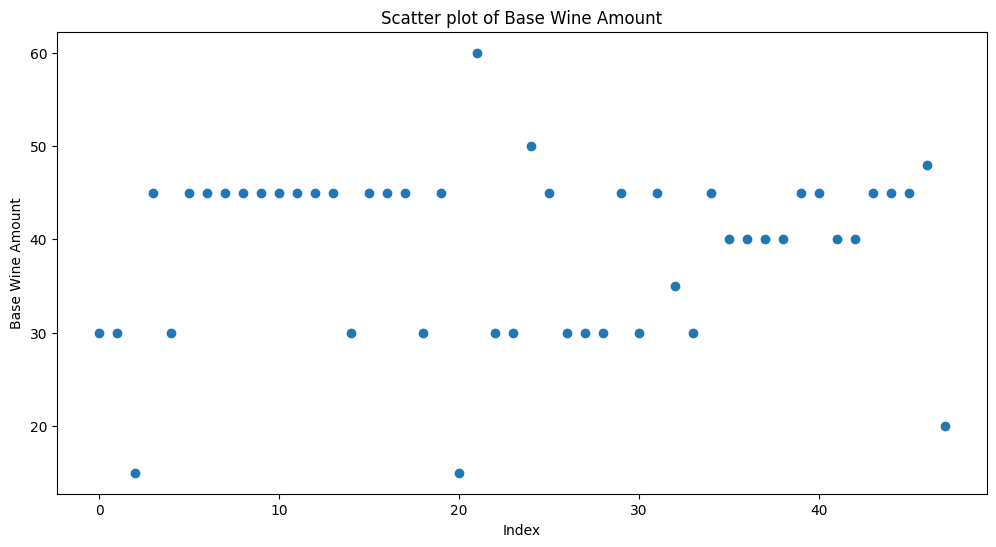

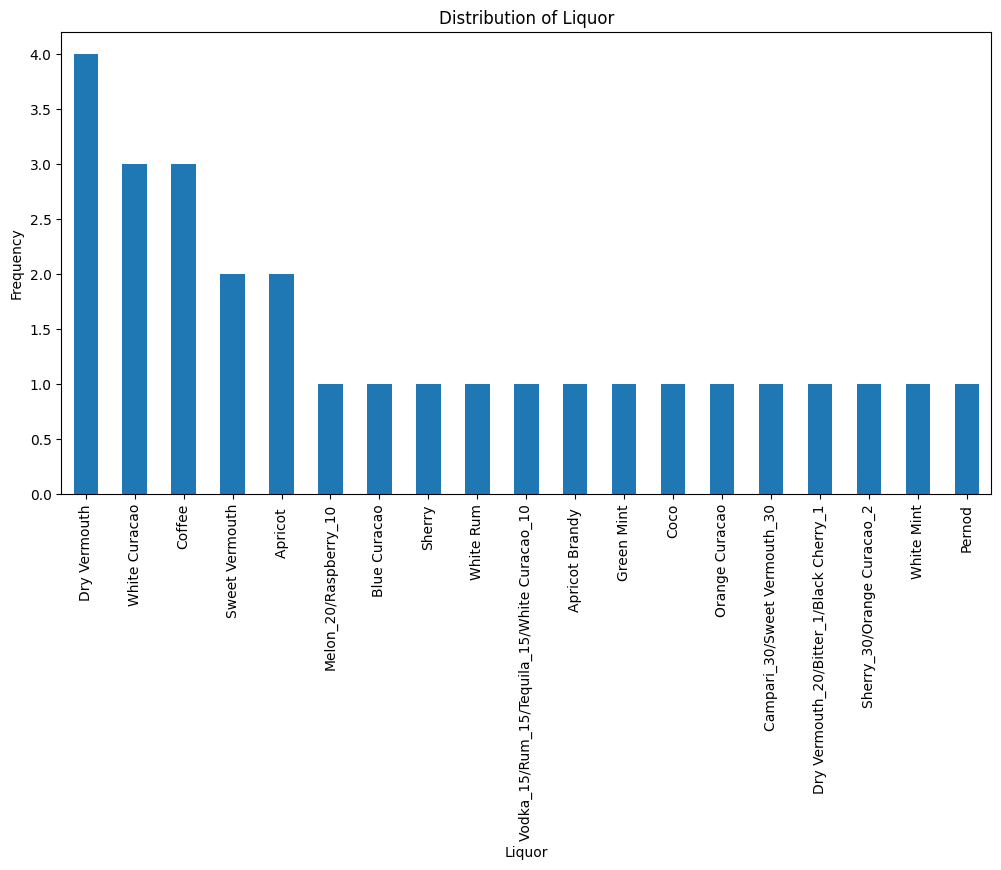

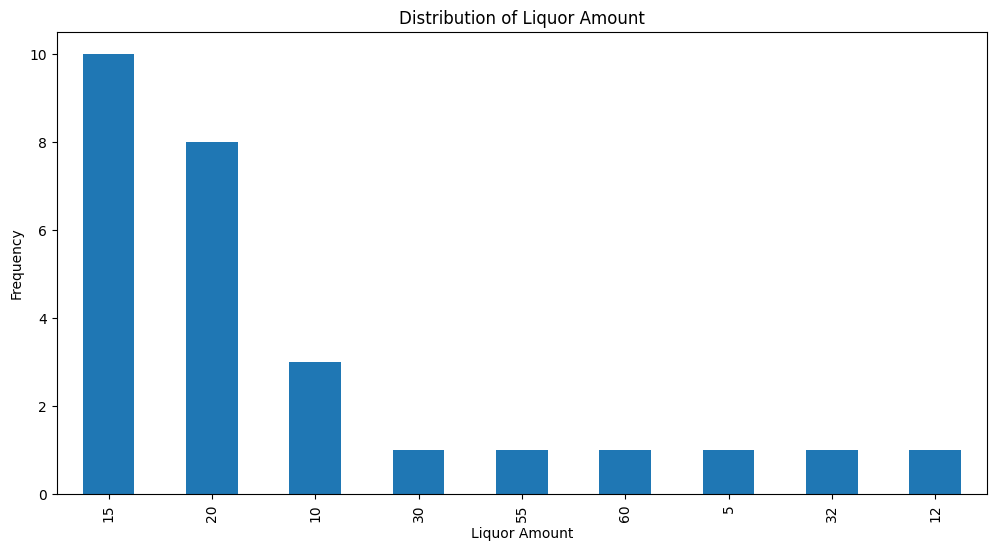

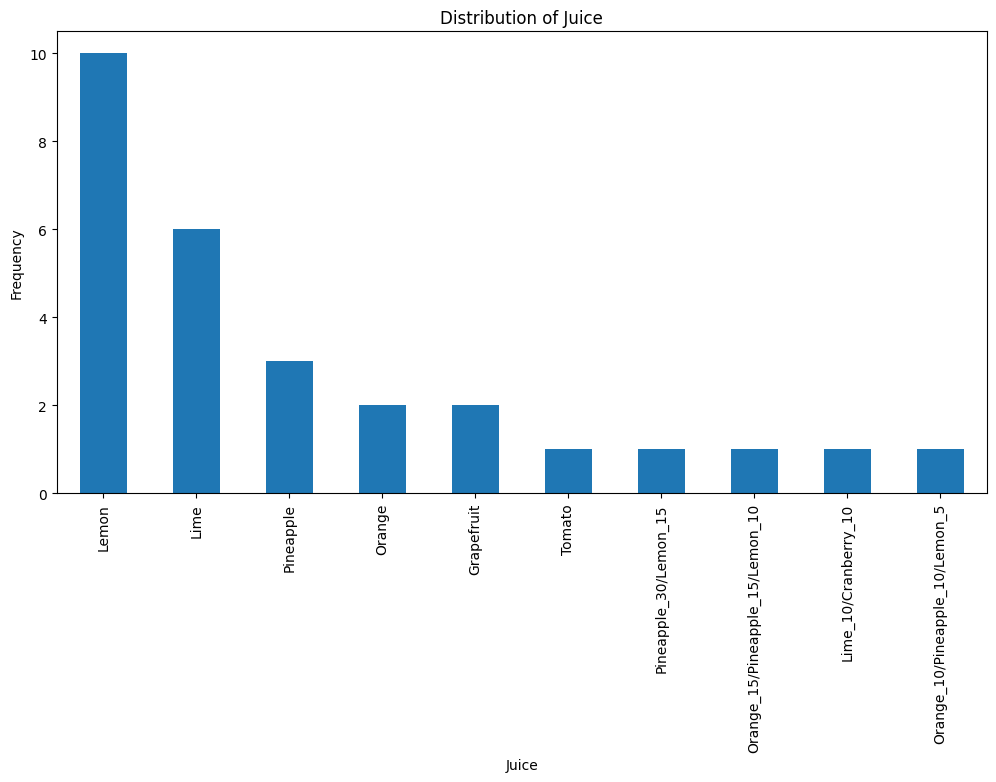

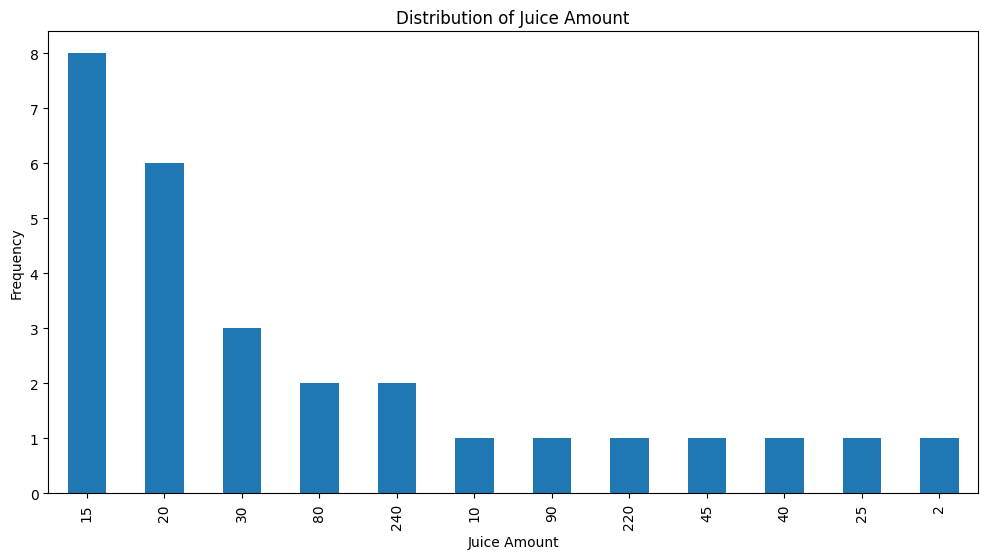

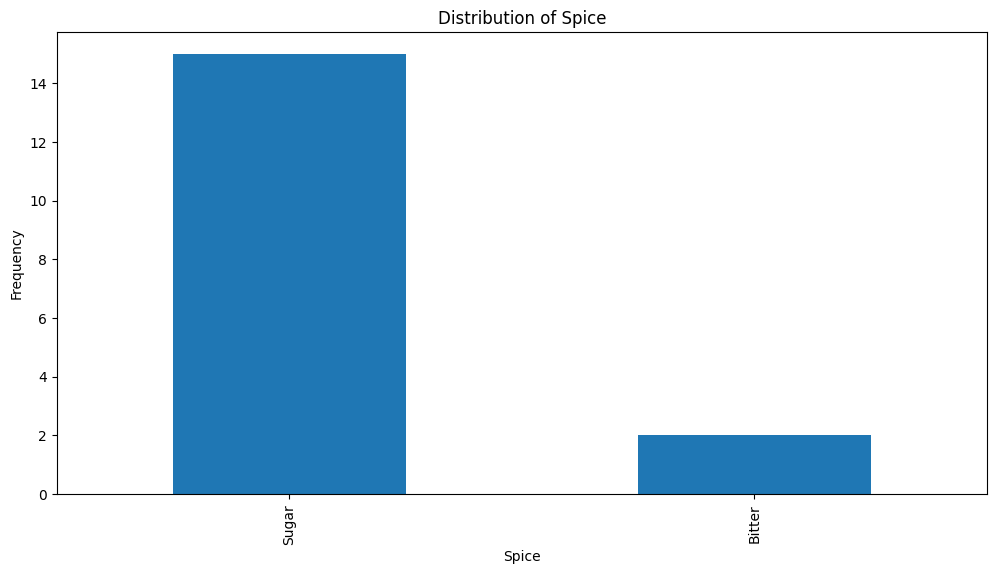

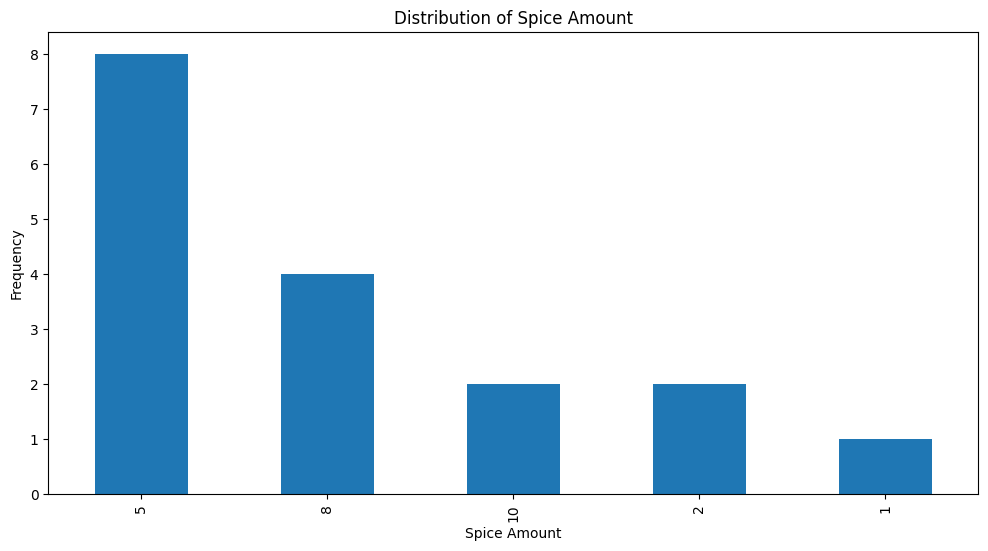

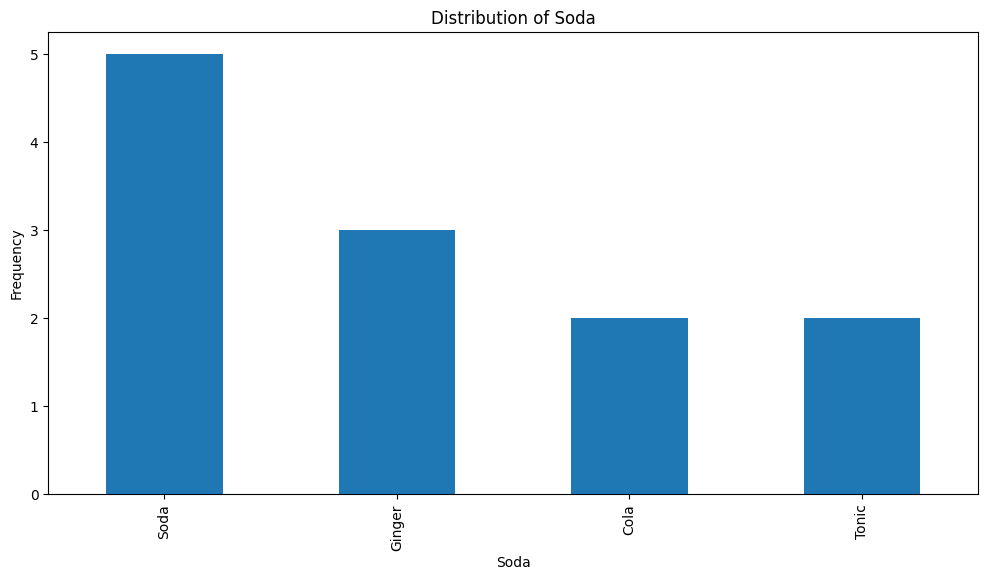

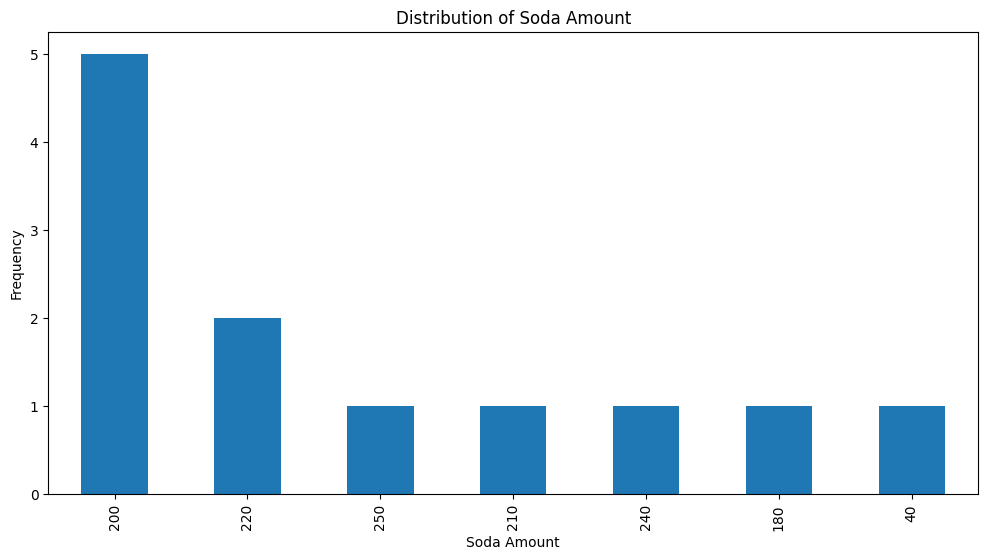

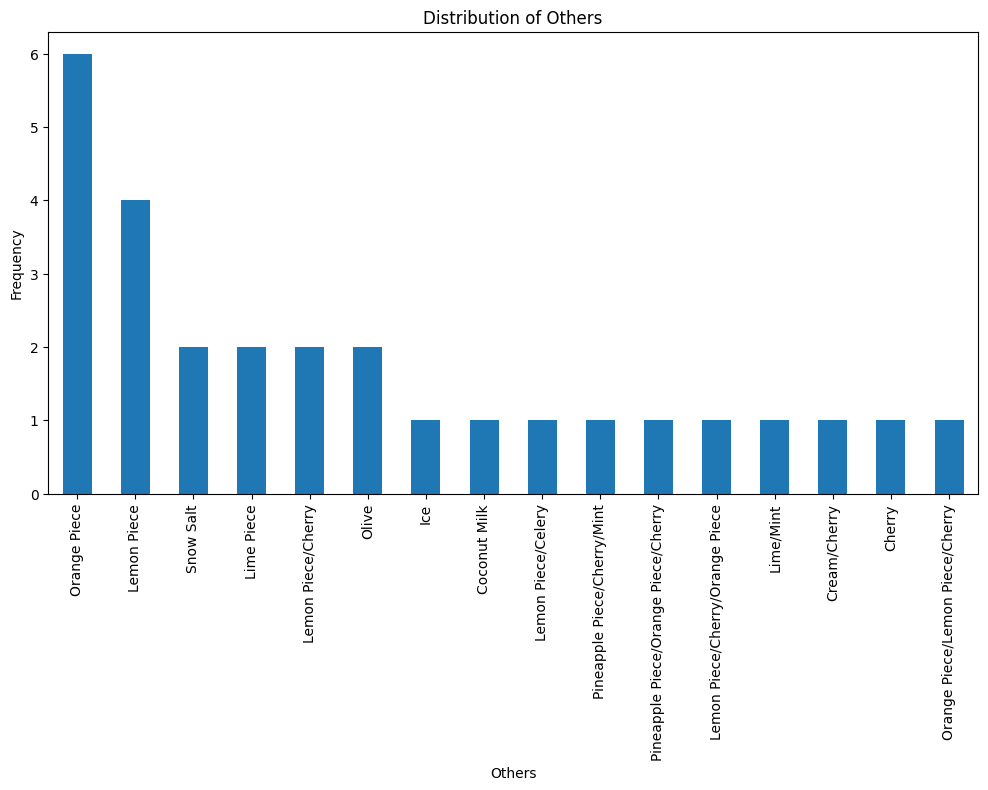

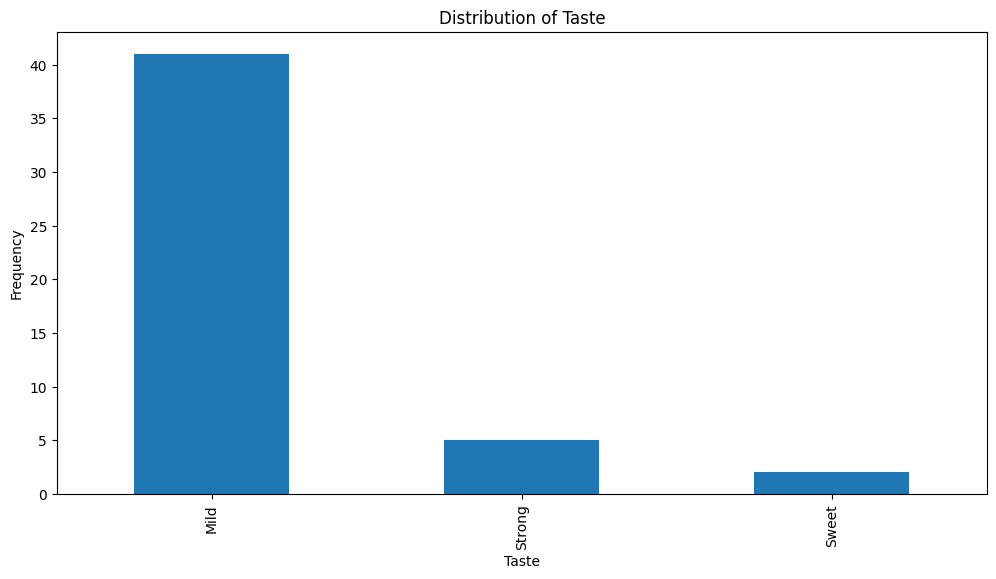

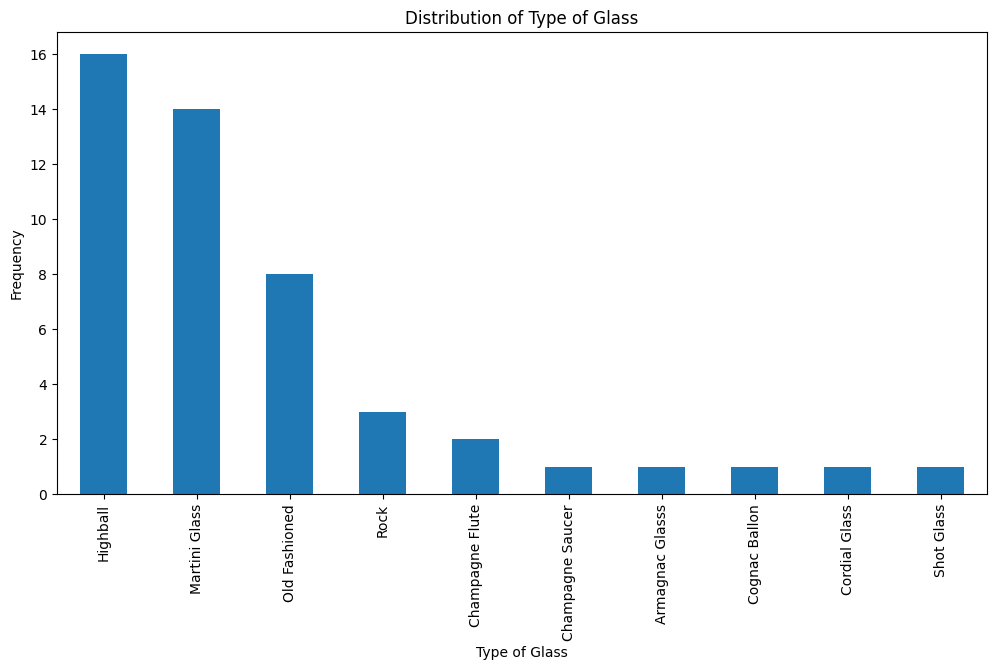

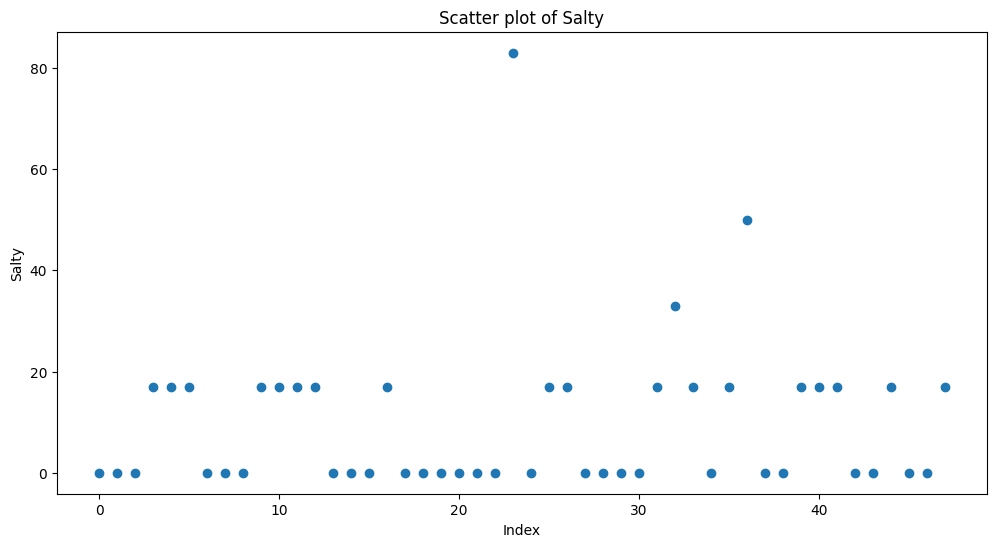

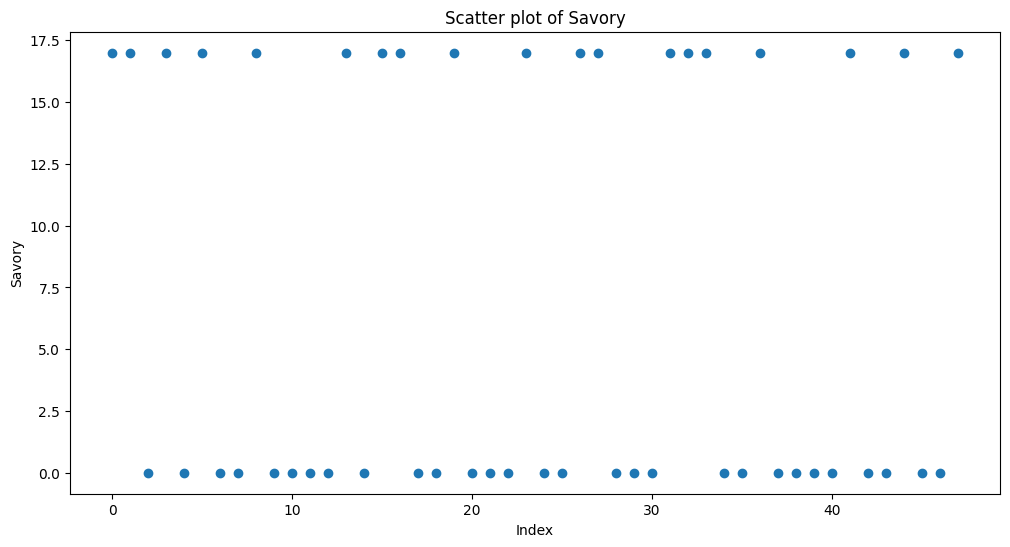

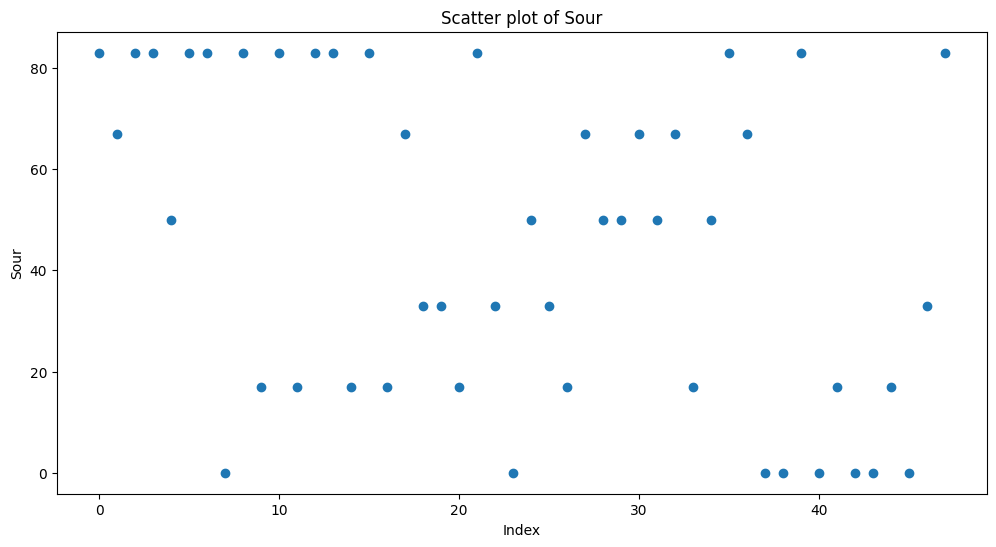

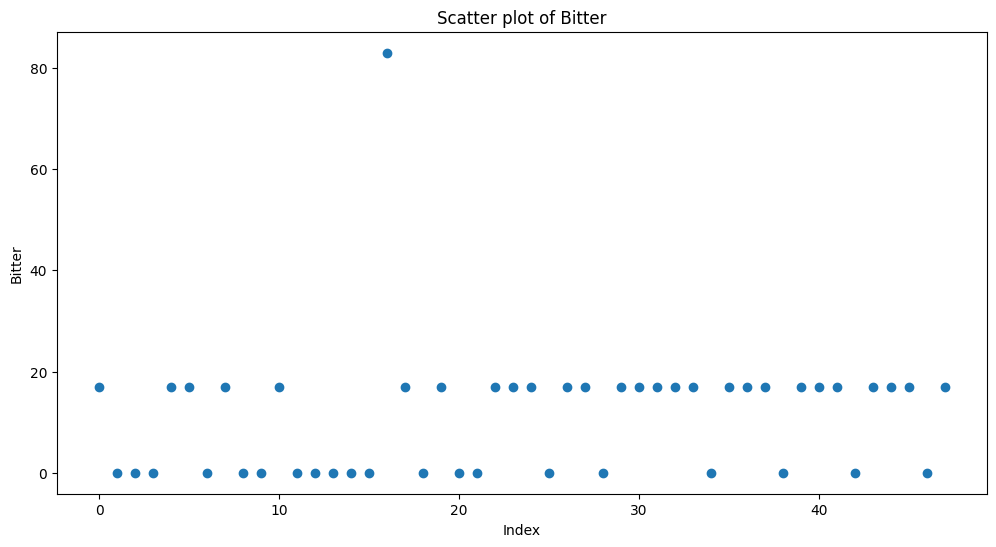

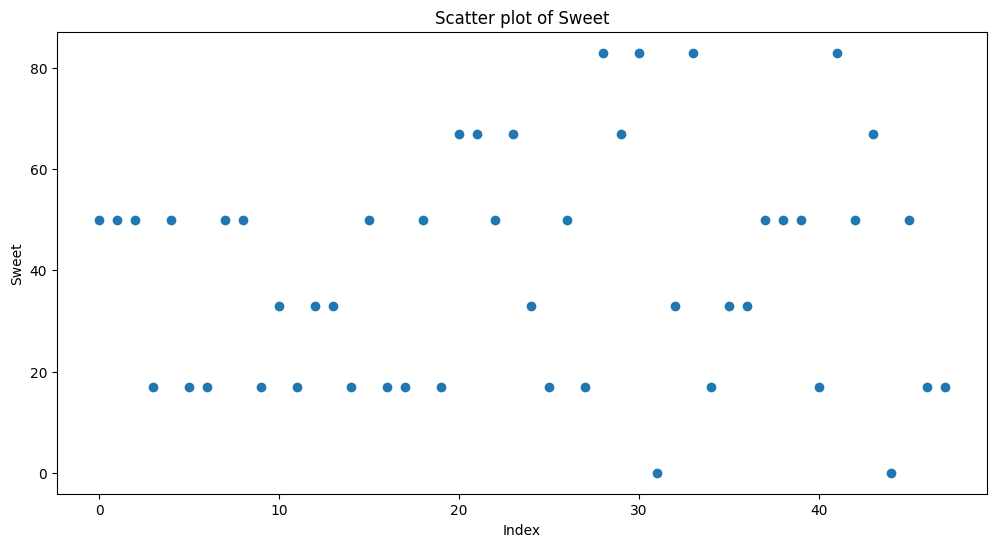

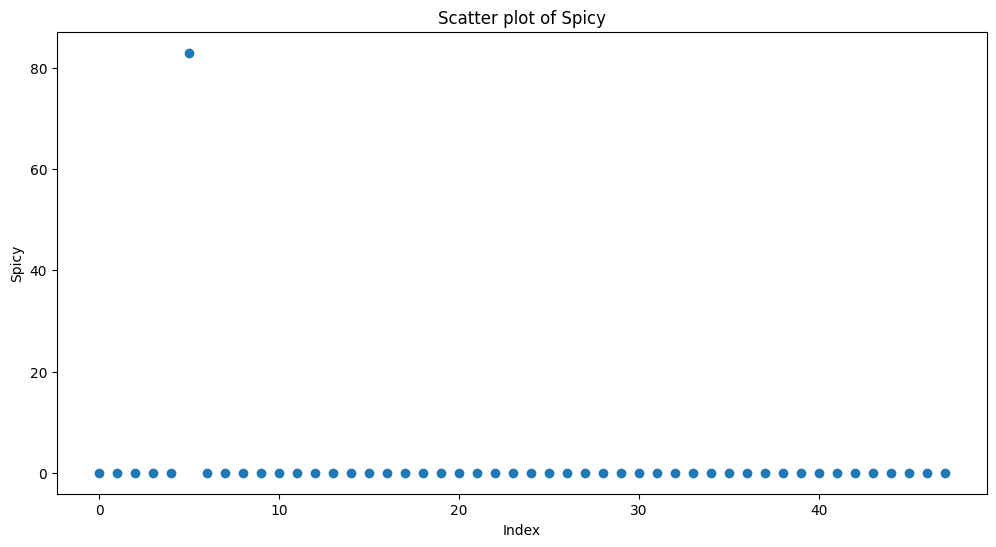

In [6]:
# EDA on cocktails data
def eda_cocktails(data):
    print("Cocktails Data Info:")
    print(data.info())
    # Summary Statistics
    print("\nCocktails Data Description:")
    print(data.describe())

    for column in data.columns:
        plt.figure(figsize=(12, 6))
        
        if data[column].dtype == 'object':
            # Categorical column - Bar plot
            data[column].value_counts().plot(kind='bar')
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
        else:
            # Numerical column - Scatter plot
            plt.scatter(data.index, data[column])
            plt.title(f'Scatter plot of {column}')
            plt.xlabel('Index')
            plt.ylabel(column)
        
        plt.show()

# Perform EDA
eda_cocktails(cocktails_df)

Text(0, 0.5, 'Alcohol Content')

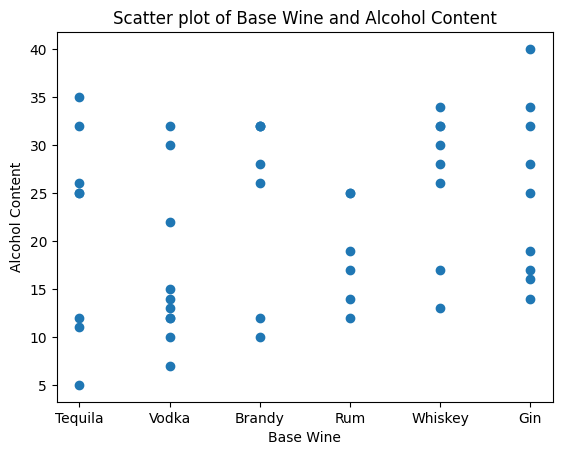

In [7]:
plt.scatter(cocktails_df['Base Wine'], cocktails_df['Alcohol'])
plt.title(f'Scatter plot of Base Wine and Alcohol Content')
plt.xlabel('Base Wine')
plt.ylabel('Alcohol Content')

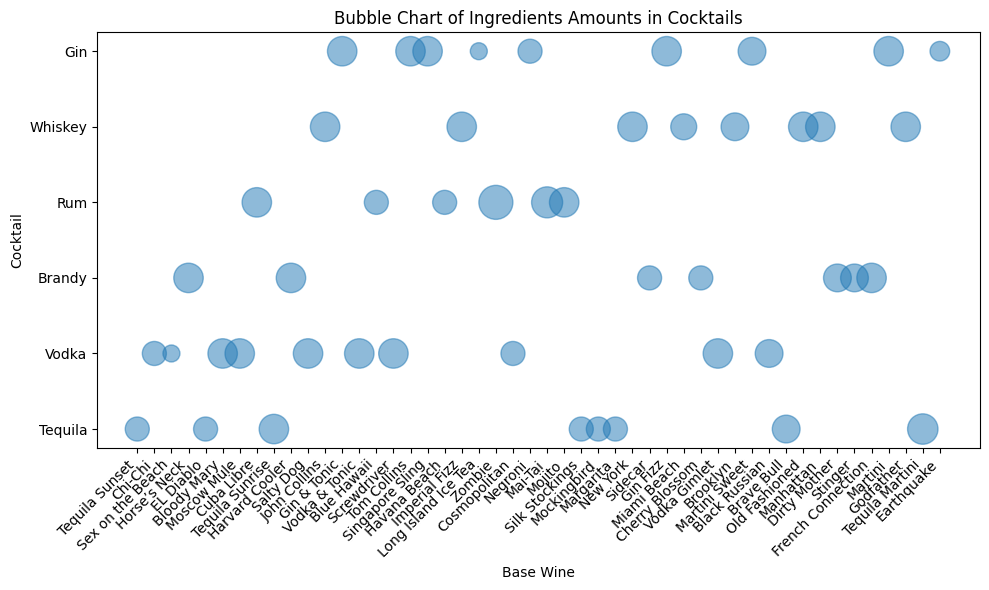

In [8]:
# Plotting bubble chart
plt.figure(figsize=(10, 6))
plt.scatter(cocktails_df['Name'], cocktails_df['Base Wine'], s=cocktails_df['Base Wine Amount']*10, alpha=0.5)
plt.xlabel('Base Wine')
plt.ylabel('Cocktail')
plt.title('Bubble Chart of Ingredients Amounts in Cocktails')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Correlation Analysis

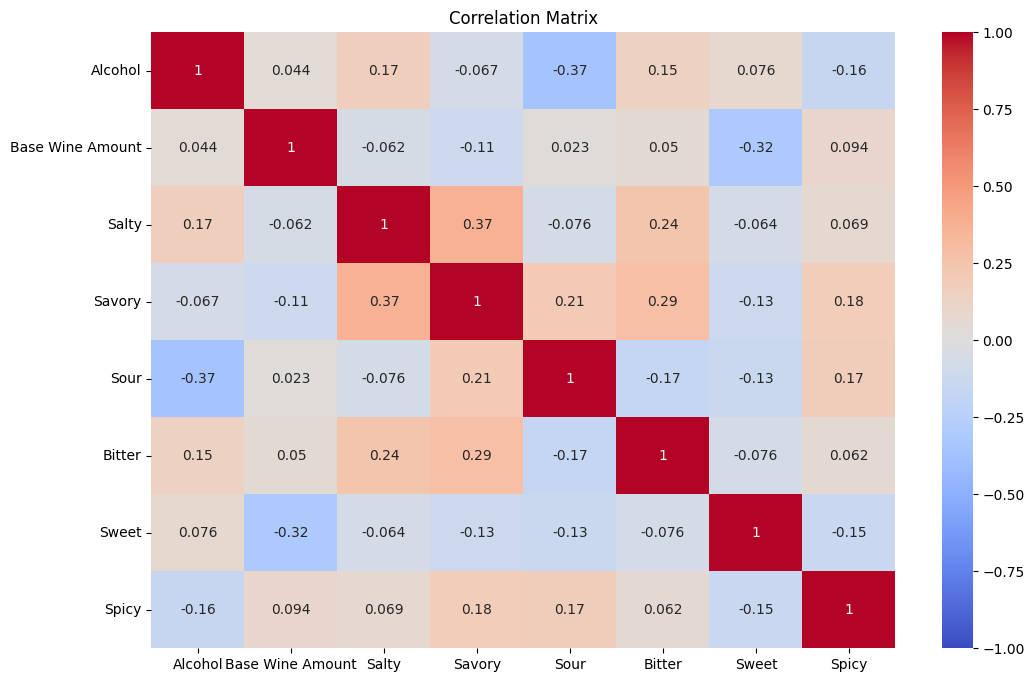

In [9]:
# Plot correlation matrix
# Select only numerical columns
numerical_cols = cocktails_df.select_dtypes(include=[np.number])

# Compute the correlation matrix for numerical columns
corr_matrix = numerical_cols.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig(f'images/corrmatrix.png')
plt.show()

### Handle Missing Values

In [10]:
# Since the cocktails recipes are set there would not be a case to fill in missing values. If the data was truly missing then we would be an associate to fill in the correct information

## Feature Scaling

In [11]:
# Scale numerical columns
numerical_cols = cocktails_df.select_dtypes(include=['number']).columns
print(numerical_cols)
scaler = StandardScaler()
cocktails_df[numerical_cols] = scaler.fit_transform(cocktails_df[numerical_cols])

cocktails_df.head()

Index(['Alcohol', 'Base Wine Amount', 'Salty', 'Savory', 'Sour', 'Bitter',
       'Sweet', 'Spicy'],
      dtype='object')


,Alcohol,Name,Category,Making,Base Wine,Base Wine Amount,Liquor,Liquor Amount,Juice,Juice Amount,...,Soda Amount,Others,Taste,Type of Glass,Salty,Savory,Sour,Bitter,Sweet,Spicy
0,-1.901512,Tequila Sunset,Short,Blend,Tequila,-1.002448,None,None,Lemon,30,...,None,Ice,Mild,Champagne Saucer,-0.648430,1.235442,1.196735,0.427160,0.462927,-0.145865
1,-1.678624,Chi-Chi,Long,Shake,Vodka,-1.002448,None,None,Pineapple,80,...,None,Coconut Milk,Mild,Armagnac Glasss,-0.648430,1.235442,0.686695,-0.844967,0.462927,-0.145865
2,-1.344292,Sex on the Beach,Long,Build,Vodka,-2.650309,Melon_20/Raspberry_10,30,Pineapple,80,...,None,None,Mild,Highball,-0.648430,-0.809427,1.196735,-0.844967,0.462927,-0.145865
3,-1.344292,Horse’s Neck,Long,Build,Brandy,0.645412,None,None,None,None,...,200,Lemon Piece,Mild,Old Fashioned,0.472585,1.235442,1.196735,-0.844967,-1.012479,-0.145865
4,-1.232848,EL Diablo,Long,Build,Tequila,-1.002448,None,None,None,None,...,250,Orange Piece,Mild,Highball,0.472585,-0.809427,0.144777,0.427160,0.462927,-0.145865


### One-Hot Encode Categorical Variables

In [12]:
# One-Hot Encode categorical columns, except the cocktail name column
categorical_cols = cocktails_df.drop(columns='Name').select_dtypes(include=['object']).columns
print(categorical_cols)
cocktails_df = pd.get_dummies(cocktails_df, columns=categorical_cols)

# Convert boolean columns to integers
boolean_cols = cocktails_df.select_dtypes(include=['bool']).columns
cocktails_df[boolean_cols] = cocktails_df[boolean_cols].astype(int)

Index(['Category', 'Making', 'Base Wine', 'Liquor', 'Liquor Amount', 'Juice',
       'Juice Amount', 'Spice', 'Spice Amount', 'Soda', 'Soda Amount',
       'Others', 'Taste', 'Type of Glass'],
      dtype='object')


In [13]:
# Add a new column 'cocktail_id' with ascending numerical mapping
cocktails_df['cocktail_id'] = range(1, len(cocktails_df) + 1)

cocktails_df.head()

/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/1106900956.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cocktails_df['cocktail_id'] = range(1, len(cocktails_df) + 1)


,Alcohol,Name,Base Wine Amount,Salty,Savory,Sour,Bitter,Sweet,Spicy,Category_Long,...,Type of Glass_Champagne Flute,Type of Glass_Champagne Saucer,Type of Glass_Cognac Ballon,Type of Glass_Cordial Glass,Type of Glass_Highball,Type of Glass_Martini Glass,Type of Glass_Old Fashioned,Type of Glass_Rock,Type of Glass_Shot Glass,cocktail_id
0,-1.901512,Tequila Sunset,-1.002448,-0.648430,1.235442,1.196735,0.427160,0.462927,-0.145865,0,...,0,1,0,0,0,0,0,0,0,1
1,-1.678624,Chi-Chi,-1.002448,-0.648430,1.235442,0.686695,-0.844967,0.462927,-0.145865,1,...,0,0,0,0,0,0,0,0,0,2
2,-1.344292,Sex on the Beach,-2.650309,-0.648430,-0.809427,1.196735,-0.844967,0.462927,-0.145865,1,...,0,0,0,0,1,0,0,0,0,3
3,-1.344292,Horse’s Neck,0.645412,0.472585,1.235442,1.196735,-0.844967,-1.012479,-0.145865,1,...,0,0,0,0,0,0,1,0,0,4
4,-1.232848,EL Diablo,-1.002448,0.472585,-0.809427,0.144777,0.427160,0.462927,-0.145865,1,...,0,0,0,0,1,0,0,0,0,5


In [14]:
cocktails_df.columns

Index(['Alcohol', 'Name', 'Base Wine Amount', 'Salty', 'Savory', 'Sour',
       'Bitter', 'Sweet', 'Spicy', 'Category_Long',
       ...
       'Type of Glass_Champagne Flute', 'Type of Glass_Champagne Saucer',
       'Type of Glass_Cognac Ballon', 'Type of Glass_Cordial Glass',
       'Type of Glass_Highball', 'Type of Glass_Martini Glass',
       'Type of Glass_Old Fashioned', 'Type of Glass_Rock',
       'Type of Glass_Shot Glass', 'cocktail_id'],
      dtype='object', length=119)

### Correlation Analysis - Feature Scaling

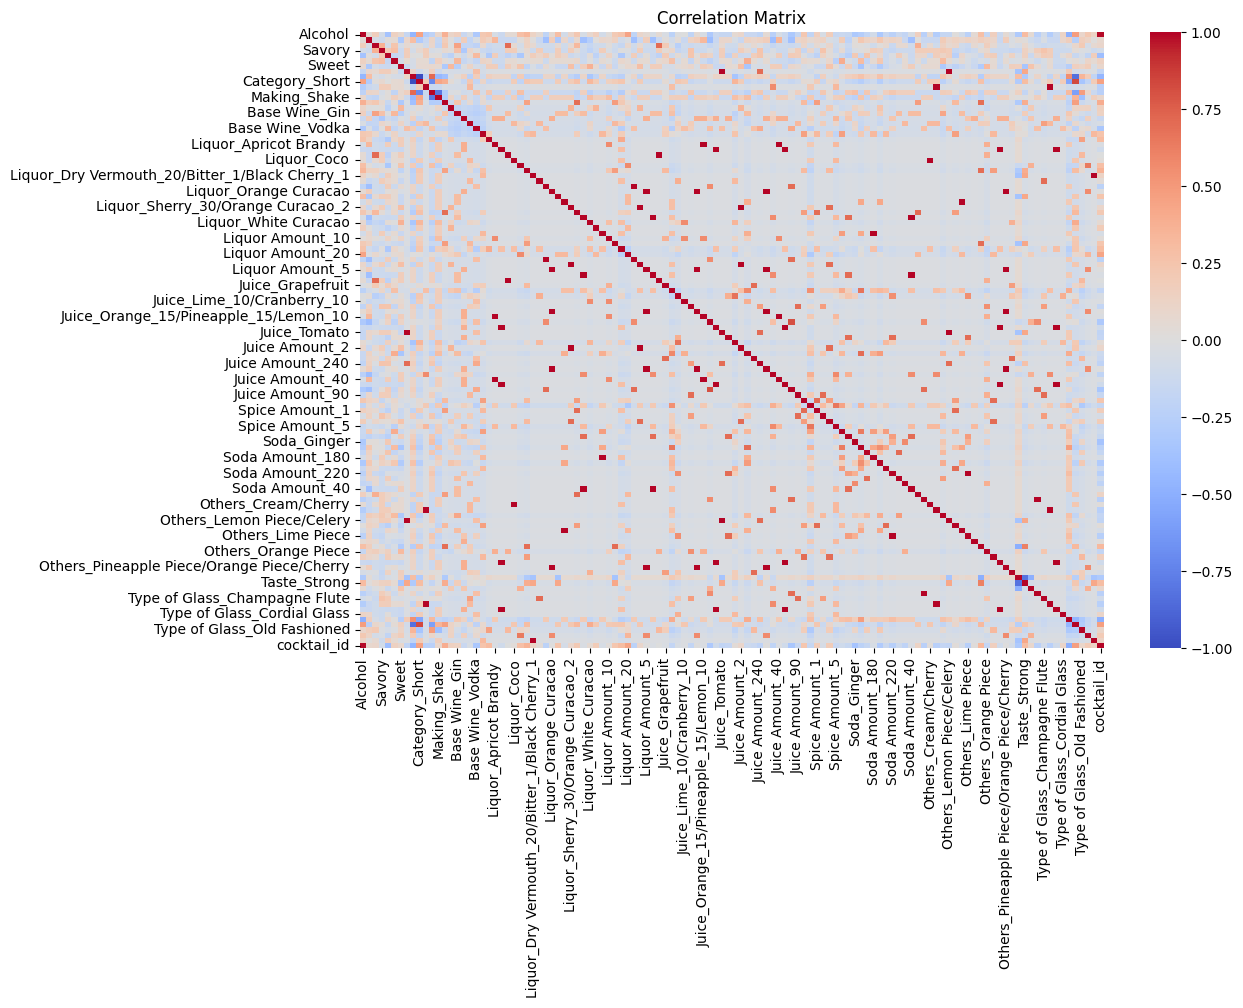

In [16]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = cocktails_df.drop(columns = 'Name').corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig(f'images/corrmatrix_featurescaling.png')
plt.show()

## Importing User Ratings

In [47]:
# Importing Ratings Data Raw

# Assuming 'cocktails_df' is predefined with cocktail names
cocktail_ids = cocktails_df.set_index('Name')['cocktail_id'].to_dict()

# Load the CSV file
file_path = 'spreadsheets/user_ratings_form.csv'
ratings_df = pd.read_csv(file_path)
print(ratings_df.columns)
print(ratings_df.shape)

# Ensure necessary columns are present
assert 'Name' in cocktails_df.columns, "'Name' column missing in cocktails_df"
assert 'Email' in ratings_df.columns, "'Email' column missing in ratings_df"
assert 'Cocktail' in ratings_df.columns, "'Cocktail' column missing in ratings_df"
assert 'Rating (1=do not like, 5 = like very much)' in ratings_df.columns, "'Rating' column missing in ratings_df"

# Generate user_id by factorizing the 'Email' column and starting from 1
ratings_df['Email'] = ratings_df['Email'].str.strip()
ratings_df['user_id'] = ratings_df['Email'].factorize()[0] + 1

ratings_df.rename(columns={'Rating (1=do not like, 5 = like very much)': 'user_rating'}, inplace=True)

# Check the number of unique users in ratings_df
num_unique_users = ratings_df['user_id'].nunique()
print(f"Number of unique users: {num_unique_users}")
# print(ratings_df['Email'].unique())

# user_email_id = ratings_df

ratings_df['cocktail_id'] = ratings_df['Cocktail'].map(cocktail_ids)
ratings_df = ratings_df[['user_id', 'cocktail_id', 'user_rating']]

print(ratings_df)

Index(['Timestamp', 'Email', 'Your Name', 'Cocktail',
       'Rating (1=do not like, 5 = like very much)'],
      dtype='object')
(115, 5)
Number of unique users: 47
     user_id  cocktail_id  user_rating
0          1           41            4
1          2           17            5
2          2           13            4
3          3           26            4
4          2           26            4
..       ...          ...          ...
110       33           16            5
111       46            1            5
112       47            6            1
113       47           21            3
114       47           26            5

[115 rows x 3 columns]


## Model Building

In [27]:
# Run for Real Data Set

# recommended_names = cocktails_df[cocktails_df['cocktail_id'].isin(recommended_cocktails)][['cocktail_id', 'Name']]

# Function to create item-based collaborative filtering recommendations
def item_based_recommender(ratings_df, cocktails_df, user_ids, num_recommendations, export_filename):
    user_item_matrix = ratings_df.pivot_table(index='user_id', columns='cocktail_id', values='user_rating')
    user_item_matrix = user_item_matrix.fillna(0)
    item_similarity = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
    
    recommendations = {}
    # if isinstance(user_ids, int):
    #     user_ids = [user_ids]
    
    actual_num_users = user_item_matrix.shape[0]
    # for user in range(min(num_users, actual_num_users)):
    #     user_ratings = user_item_matrix.iloc[user, :]
    for user in user_ids:
        user_ratings = user_item_matrix.loc[user, :]
        user_rated_cocktails = user_ratings[user_ratings > 0].index
        user_recommendations = user_ratings.dot(item_similarity_df) / item_similarity_df.sum(axis=1)
        user_recommendations = user_recommendations.sort_values(ascending=False)
        recommended_cocktails = [cocktail for cocktail in user_recommendations.index if cocktail not in user_rated_cocktails][:num_recommendations]
        # recommended_cocktails = user_recommendations.index[:num_recommendations].tolist()
        recommended_names = cocktails_df[cocktails_df['cocktail_id'].isin(recommended_cocktails)][['cocktail_id', 'Name']]
        recommendations[user] = recommended_names.set_index('cocktail_id').loc[recommended_cocktails]['Name'].tolist()
    
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
    recommendations_df.to_csv(export_filename + '_item_based.csv', index_label='user_id')
    return recommendations_df

# Function to create user-based collaborative filtering recommendations
def user_based_recommender(ratings_df, cocktails_df, user_ids, num_neighbors, num_recommendations, export_filename):
    user_item_matrix = ratings_df.pivot_table(index='user_id', columns='cocktail_id', values='user_rating')
    user_item_matrix = user_item_matrix.fillna(0)
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
    user_similarity_df.to_csv('spreadsheets/user_similarity_df.csv', index=True)
    
    recommendations = {}
    actual_num_users = user_item_matrix.shape[0]
    # for user in range(min(num_users, actual_num_users)):
    #     user_similarities = user_similarity_df.iloc[user, :]
    for user in user_ids:
        
        user_similarities = user_similarity_df.loc[user, :]
        similar_users = user_similarities.sort_values(ascending=False).index[1:num_neighbors+1]
        similar_users_ratings = user_item_matrix.loc[similar_users, :]
        user_recommendations = similar_users_ratings.T.dot(user_similarities[similar_users]) / user_similarities[similar_users].sum()
        user_recommendations = user_recommendations.sort_values(ascending=False)
        user_rated_cocktails = user_item_matrix.loc[user][user_item_matrix.loc[user] > 0].index
        recommended_cocktails = [cocktail for cocktail in user_recommendations.index if cocktail not in user_rated_cocktails][:num_recommendations]
        # recommended_cocktails = user_recommendations.index[:num_recommendations].tolist()
        recommended_names = cocktails_df[cocktails_df['cocktail_id'].isin(recommended_cocktails)][['cocktail_id', 'Name']]
        recommendations[user] = recommended_names.set_index('cocktail_id').loc[recommended_cocktails]['Name'].tolist()
    
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
    recommendations_df.to_csv(export_filename + '_user_based.csv', index_label='user_id')
    return recommendations_df

# Function to create content-based filtering recommendations
def content_based_recommender(ratings_df, cocktails_df, user_ids, num_recommendations, export_filename):
    cocktail_features = cocktails_df.apply(lambda x: ' '.join(x.astype(str)), axis=1)
    vectorizer = CountVectorizer().fit_transform(cocktail_features)
    cocktail_vectors = vectorizer.toarray()
    content_similarity = cosine_similarity(cocktail_vectors)
    content_similarity_df = pd.DataFrame(content_similarity, index=cocktails_df['cocktail_id'], columns=cocktails_df['cocktail_id'])
    
    recommendations = {}
    user_item_matrix = ratings_df.pivot_table(index='user_id', columns='cocktail_id', values='user_rating').fillna(0)
    actual_num_users = user_item_matrix.shape[0]
    # for user in range(min(num_users, actual_num_users)):
    #     user_ratings = user_item_matrix.iloc[user, :]
    for user in user_ids:
        user_ratings = user_item_matrix.loc[user, :]
        user_rated_cocktails = user_ratings[user_ratings > 0].index
        user_recommendations = pd.Series(dtype='float64')
        for cocktail in user_rated_cocktails:
            similar_cocktails = content_similarity_df[cocktail].sort_values(ascending=False).iloc[1:num_recommendations+1]
            similar_cocktails = pd.Series(similar_cocktails.index)
            if not similar_cocktails.empty:
                user_recommendations = pd.concat([user_recommendations, similar_cocktails])
        user_recommendations = user_recommendations.value_counts().sort_values(ascending=False)
        recommended_cocktails = [cocktail for cocktail in user_recommendations.index if cocktail not in user_rated_cocktails][:num_recommendations]
        # recommended_cocktails = user_recommendations.index[:num_recommendations].tolist()
        recommended_names = cocktails_df[cocktails_df['cocktail_id'].isin(recommended_cocktails)][['cocktail_id', 'Name']]
        recommendations[user] = recommended_names.set_index('cocktail_id').loc[recommended_cocktails]['Name'].tolist()
    
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
    recommendations_df.to_csv(export_filename + '_content_based.csv', index_label='user_id')
    return recommendations_df

# Function to create SVD-based collaborative filtering recommendations
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Function to create SVD-based collaborative filtering recommendations
def svd_recommender(ratings_df, cocktails_df, user_ids, num_recommendations, export_filename):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'cocktail_id', 'user_rating']], reader)
    
    # Use surprise's built-in train_test_split
    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)
    
    # Train the SVD algorithm
    algo = SVD()
    algo.fit(trainset)
    
    recommendations = {}
    actual_num_users = len(ratings_df['user_id'].unique())
    # for user in range(1, min(num_users, actual_num_users) + 1):
    #     user_ratings = ratings_df[ratings_df['user_id'] == user]
    for user in user_ids:
        user_ratings = ratings_df[ratings_df['user_id'] == user]
        user_cocktail_ids = user_ratings['cocktail_id'].tolist()
        user_recommendations = []
        for cocktail_id in cocktails_df['cocktail_id']:
            if cocktail_id not in user_cocktail_ids:
                prediction = algo.predict(user, cocktail_id)
                user_recommendations.append((cocktail_id, prediction.est))
        user_recommendations.sort(key=lambda x: x[1], reverse=True)
        recommended_cocktails = [cocktail_id for cocktail_id, _ in user_recommendations[:num_recommendations]]
        # recommended_cocktails = [cocktail_id for cocktail_id, _ in user_recommendations[:num_recommendations]]
        recommended_names = cocktails_df[cocktails_df['cocktail_id'].isin(recommended_cocktails)][['cocktail_id', 'Name']]
        recommendations[user] = recommended_names.set_index('cocktail_id').loc[recommended_cocktails]['Name'].tolist()
    
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
    recommendations_df.to_csv(export_filename + '_svd.csv', index_label='user_id')
    return recommendations_df

# Example usage:
# svd_recommendations = svd_recommender(ratings_df, cocktails_df, user_ids, num_recommendations, 'recs/svd_recommendations')

### Applying Model to Real Dataset

In [28]:
print(cocktails_df.columns)


Index(['Alcohol', 'Name', 'Base Wine Amount', 'Salty', 'Savory', 'Sour',
       'Bitter', 'Sweet', 'Spicy', 'Category_Long',
       ...
       'Type of Glass_Champagne Flute', 'Type of Glass_Champagne Saucer',
       'Type of Glass_Cognac Ballon', 'Type of Glass_Cordial Glass',
       'Type of Glass_Highball', 'Type of Glass_Martini Glass',
       'Type of Glass_Old Fashioned', 'Type of Glass_Rock',
       'Type of Glass_Shot Glass', 'cocktail_id'],
      dtype='object', length=119)


In [29]:
num_users = 2
user_ids = [2, 38, 47]
num_neighbors = 10
num_recommendations = 3
export_filename = 'recommendations'

item_based_recommendations = item_based_recommender(ratings_df, cocktails_df, user_ids, num_recommendations, 'spreadsheets/item_based_recommendations')
user_based_recommendations = user_based_recommender(ratings_df, cocktails_df, user_ids, num_neighbors, num_recommendations, 'spreadsheets/user_based_recommendations')
content_based_recommendations = content_based_recommender(ratings_df, cocktails_df, user_ids, num_recommendations, 'spreadsheets/content_based_recommendations')
svd_recommendations = svd_recommender(ratings_df, cocktails_df, user_ids, num_recommendations, 'spreadsheets/svd_recommendations')

/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/2611748024.py:83: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  user_recommendations = pd.concat([user_recommendations, similar_cocktails])
/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/2611748024.py:83: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  user_recommendations = pd.concat([user_recommendations, similar_cocktails])
/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/2611748024.py:83: FutureWarning: The behavior of array concatenation with empty entri

In [30]:
import pandas as pd

# Load user_similarity_df
user_similarity_df = pd.read_csv('spreadsheets/user_similarity_df.csv', index_col=0)

# Convert the columns to integers
user_similarity_df.columns = user_similarity_df.columns.astype(int)

# Print the first few rows to understand the structure and check columns
# print(user_similarity_df.head())
print(user_similarity_df.columns)

# Ensure that the column for user 2 exists
if 2 not in user_similarity_df.columns:
    print("User 2 is not found in the columns of user_similarity_df")
else:
    # 1. Identify the most similar user to user 2 (excluding user 2 itself)
    similarities = user_similarity_df[2]  # Extract the column for user 2
    most_similar_user = similarities.drop(index=2).idxmax()

    print(f"The most similar user to user 2 is user {most_similar_user}")

    # 2. Retrieve the drinks rated by this most similar user
    similar_user_ratings = user_email_id[user_email_id['user_id'] == most_similar_user]
    # print(user_email_id)
    
    print(f"Drinks rated by user {most_similar_user}:")
    print(similar_user_ratings[['Cocktail', 'user_rating']])


Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
      dtype='int64')
The most similar user to user 2 is user 38
Drinks rated by user 38:
               Cocktail  user_rating
80          Gin & Tonic            5
81          Moscow Mule            5
82       Tequila Sunset            3
83          Bloody Mary            5
84        Vodka & Tonic            3
85          Blue Hawaii            4
86          Screwdriver            1
87          Tom Collins            4
88  Long Island Ice Tea            4
93            Margarita            5
96            Manhattan            4


### Synthetic User Rating

In [33]:
# Generate synthetic user ratings data
def generate_synthetic_ratings(num_users, num_ratings, cocktails_df):
    np.random.seed(42)

    ratings = [1, 2, 3, 4, 5]
    probabilities = [0.1, 0.05, 0.15, 0.25, 0.45]

    user_ids = pd.Series(np.random.randint(1, num_users + 1, num_ratings)).astype(str)
    cocktail_names = np.random.choice(cocktails_df['Name'].unique(), num_ratings)
    user_ratings = np.random.normal(loc=3, scale=1, size=num_ratings).astype(int)
    # user_ratings = np.random.choice(ratings, size=num_ratings)
    # user_ratings = np.random.choice(ratings, size=num_ratings, p=probabilities)
    
    user_ratings = np.clip(user_ratings, 1, 5)
    
    cocktail_ids = cocktails_df.set_index('Name')['cocktail_id'].to_dict()
    
    synthetic_data = pd.DataFrame({
        'user_id': user_ids,
        'cocktail_name': cocktail_names,
        'user_rating': user_ratings
    })
    
    synthetic_data['cocktail_id'] = synthetic_data['cocktail_name'].map(cocktail_ids)
    synthetic_data['user_email'] = synthetic_data['user_id'].apply(lambda x: f'user{x}@gmail.com')
    
    return synthetic_data

num_users = 2000  # Number of unique users
num_ratings = 10000  # Total number of ratings

# Generate the data once
syn_ratings_df = generate_synthetic_ratings(num_users, num_ratings, cocktails_df)

# Ensure cocktail_id is integer
syn_ratings_df['cocktail_id'] = syn_ratings_df['cocktail_id'].astype(int)

syn_ratings_df.to_csv('spreadsheets/syn_user_rating_test.csv', index=False)

syn_ratings_df2 = syn_ratings_df[['user_id', 'cocktail_id', 'user_rating']]

### Same Model as above with minor tweeks for Synthetic data

In [36]:
# # Run for Synthetic Data Set

# Function to create item-based collaborative filtering recommendations
def item_based_recommender2(ratings_df, cocktails_df, num_users, num_recommendations, export_filename):
    user_item_matrix = ratings_df.pivot_table(index='user_id', columns='cocktail_id', values='user_rating')
    user_item_matrix = user_item_matrix.fillna(0)
    item_similarity = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
    
    recommendations = {}
    # if isinstance(user_ids, int):
    #     user_ids = [user_ids]
    
    actual_num_users = user_item_matrix.shape[0]
    
    user_ids = range(1, min(num_users + 1, actual_num_users + 1))
    
    # for user in range(min(num_users, actual_num_users)):
    #     user_ratings = user_item_matrix.iloc[user, :]
    for user in user_ids:
        user_ratings = user_item_matrix.iloc[user, :]
        user_rated_cocktails = user_ratings[user_ratings > 0].index
        user_recommendations = user_ratings.dot(item_similarity_df) / item_similarity_df.sum(axis=1)
        user_recommendations = user_recommendations.sort_values(ascending=False)
        recommended_cocktails = [cocktail for cocktail in user_recommendations.index if cocktail not in user_rated_cocktails][:num_recommendations]
        # recommended_cocktails = user_recommendations.index[:num_recommendations].tolist()
        recommended_names = cocktails_df[cocktails_df['cocktail_id'].isin(recommended_cocktails)][['cocktail_id', 'Name']]
        recommendations[user] = recommended_names.set_index('cocktail_id').loc[recommended_cocktails]['Name'].tolist()
    
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
    recommendations_df.to_csv(export_filename + '_item_based.csv', index_label='user_id')
    return recommendations_df

# Function to create user-based collaborative filtering recommendations
def user_based_recommender2(ratings_df, cocktails_df, num_users, num_neighbors, num_recommendations, export_filename):
    user_item_matrix = ratings_df.pivot_table(index='user_id', columns='cocktail_id', values='user_rating')
    user_item_matrix = user_item_matrix.fillna(0)
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
    user_similarity_df.to_csv('spreadsheets/syn_user_similarity_df.csv', index=True)
    
    recommendations = {}
    actual_num_users = user_item_matrix.shape[0]
    
    user_ids = range(1, min(num_users + 1, actual_num_users + 1))
    # for user in range(min(num_users, actual_num_users)):
    #     user_similarities = user_similarity_df.iloc[user, :]
    for user in user_ids:
        
        user_similarities = user_similarity_df.iloc[user, :]
        similar_users = user_similarities.sort_values(ascending=False).index[1:num_neighbors+1]
        similar_users_ratings = user_item_matrix.loc[similar_users, :]
        user_recommendations = similar_users_ratings.T.dot(user_similarities[similar_users]) / user_similarities[similar_users].sum()
        user_recommendations = user_recommendations.sort_values(ascending=False)
        user_rated_cocktails = user_item_matrix.iloc[user][user_item_matrix.iloc[user] > 0].index
        recommended_cocktails = [cocktail for cocktail in user_recommendations.index if cocktail not in user_rated_cocktails][:num_recommendations]
        # recommended_cocktails = user_recommendations.index[:num_recommendations].tolist()
        recommended_names = cocktails_df[cocktails_df['cocktail_id'].isin(recommended_cocktails)][['cocktail_id', 'Name']]
        recommendations[user] = recommended_names.set_index('cocktail_id').loc[recommended_cocktails]['Name'].tolist()
    
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
    recommendations_df.to_csv(export_filename + '_user_based.csv', index_label='user_id')
    return recommendations_df

# Function to create content-based filtering recommendations
def content_based_recommender2(ratings_df, cocktails_df, num_users, num_recommendations, export_filename):
    cocktail_features = cocktails_df.apply(lambda x: ' '.join(x.astype(str)), axis=1)
    vectorizer = CountVectorizer().fit_transform(cocktail_features)
    cocktail_vectors = vectorizer.toarray()
    content_similarity = cosine_similarity(cocktail_vectors)
    content_similarity_df = pd.DataFrame(content_similarity, index=cocktails_df['cocktail_id'], columns=cocktails_df['cocktail_id'])
    
    recommendations = {}
    user_item_matrix = ratings_df.pivot_table(index='user_id', columns='cocktail_id', values='user_rating').fillna(0)
    actual_num_users = user_item_matrix.shape[0]

    user_ids = range(1, min(num_users + 1, actual_num_users + 1))
    
    # for user in range(min(num_users, actual_num_users)):
    #     user_ratings = user_item_matrix.iloc[user, :]
    for user in user_ids:
        user_ratings = user_item_matrix.iloc[user, :]
        user_rated_cocktails = user_ratings[user_ratings > 0].index
        user_recommendations = pd.Series(dtype='float64')
        for cocktail in user_rated_cocktails:
            similar_cocktails = content_similarity_df[cocktail].sort_values(ascending=False).iloc[1:num_recommendations+1]
            similar_cocktails = pd.Series(similar_cocktails.index)
            if not similar_cocktails.empty:
                user_recommendations = pd.concat([user_recommendations, similar_cocktails])
        user_recommendations = user_recommendations.value_counts().sort_values(ascending=False)
        recommended_cocktails = [cocktail for cocktail in user_recommendations.index if cocktail not in user_rated_cocktails][:num_recommendations]
        # recommended_cocktails = user_recommendations.index[:num_recommendations].tolist()
        recommended_names = cocktails_df[cocktails_df['cocktail_id'].isin(recommended_cocktails)][['cocktail_id', 'Name']]
        recommendations[user] = recommended_names.set_index('cocktail_id').loc[recommended_cocktails]['Name'].tolist()
    
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
    recommendations_df.to_csv(export_filename + '_content_based.csv', index_label='user_id')
    return recommendations_df


# Function to create SVD-based collaborative filtering recommendations
def svd_recommender2(ratings_df, cocktails_df, num_users, num_recommendations, export_filename):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'cocktail_id', 'user_rating']], reader)
    
    # Use surprise's built-in train_test_split
    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)
    
    # Train the SVD algorithm
    algo = SVD()
    algo.fit(trainset)
    
    recommendations = {}
    actual_num_users = len(ratings_df['user_id'].unique())

    user_ids = range(1, min(num_users + 1, actual_num_users + 1))
    
    # for user in range(1, min(num_users, actual_num_users) + 1):
    #     user_ratings = ratings_df[ratings_df['user_id'] == user]
    for user in user_ids:
        user_ratings = ratings_df[ratings_df['user_id'] == user]
        user_cocktail_ids = user_ratings['cocktail_id'].tolist()
        user_recommendations = []
        for cocktail_id in cocktails_df['cocktail_id']:
            if cocktail_id not in user_cocktail_ids:
                prediction = algo.predict(user, cocktail_id)
                user_recommendations.append((cocktail_id, prediction.est))
        user_recommendations.sort(key=lambda x: x[1], reverse=True)
        recommended_cocktails = [cocktail_id for cocktail_id, _ in user_recommendations[:num_recommendations]]
        # recommended_cocktails = [cocktail_id for cocktail_id, _ in user_recommendations[:num_recommendations]]
        recommended_names = cocktails_df[cocktails_df['cocktail_id'].isin(recommended_cocktails)][['cocktail_id', 'Name']]
        recommendations[user] = recommended_names.set_index('cocktail_id').loc[recommended_cocktails]['Name'].tolist()
    
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
    recommendations_df.to_csv(export_filename + '_svd.csv', index_label='user_id')
    return recommendations_df

# Example usage:
# svd_recommendations = svd_recommender(ratings_df, cocktails_df, user_ids, num_recommendations, 'recs/svd_recommendations')

### Applying Model to Synthetic Dataset

In [37]:
num_users = 200 # syn_ratings_df2['user_id'].nunique()

# Call each recommender function
syn_item_based_recommendations = item_based_recommender2(syn_ratings_df2, cocktails_df, num_users, num_recommendations, 'spreadsheets/syn_item_based_recommendations')
syn_user_based_recommendations = user_based_recommender2(syn_ratings_df2, cocktails_df, num_users, num_neighbors, num_recommendations, 'spreadsheets/syn_user_based_recommendations')
syn_content_based_recommendations = content_based_recommender2(syn_ratings_df2, cocktails_df, num_users, num_recommendations, 'spreadsheets/syn_content_based_recommendations')
syn_svd_recommendations = svd_recommender2(syn_ratings_df2, cocktails_df, num_users, num_recommendations, 'spreadsheets/syn_svd_recommendations')



/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/2834513601.py:89: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  user_recommendations = pd.concat([user_recommendations, similar_cocktails])
/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/2834513601.py:89: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  user_recommendations = pd.concat([user_recommendations, similar_cocktails])
/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/2834513601.py:89: FutureWarning: The behavior of array concatenation with empty entri

## Visualizing the models

/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/355025600.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


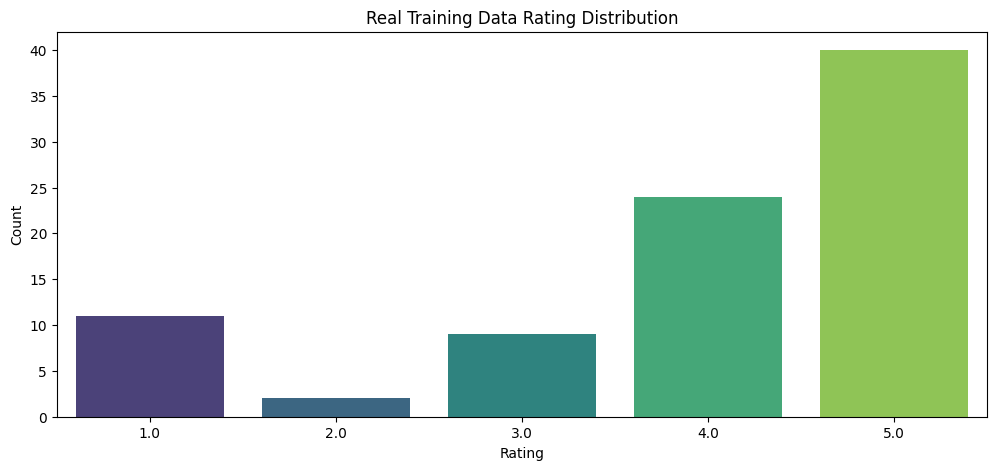

/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/355025600.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


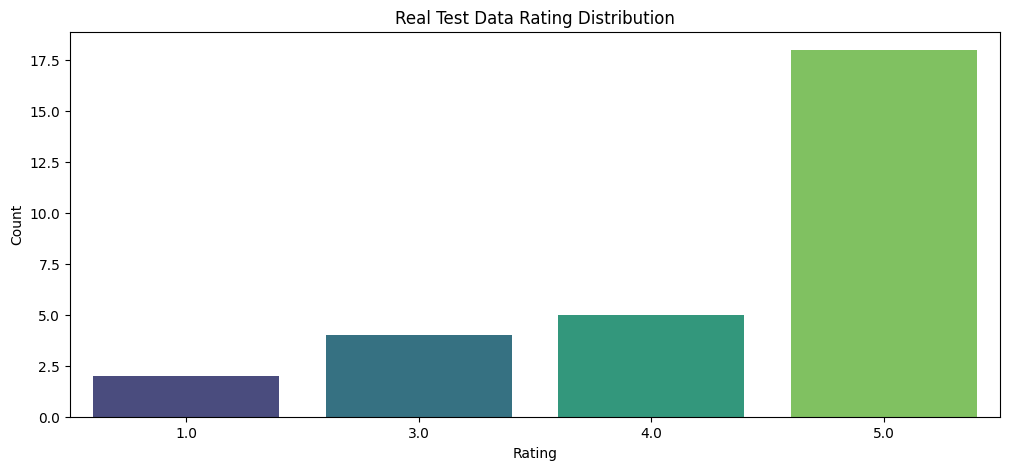

/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/355025600.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cocktail_counts.index, y=cocktail_counts.values, palette='viridis')


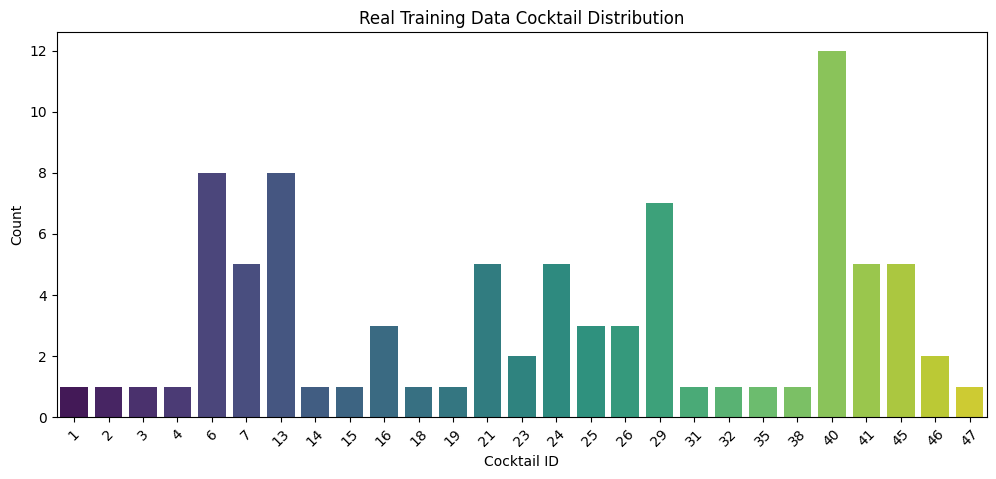

/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/355025600.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cocktail_counts.index, y=cocktail_counts.values, palette='viridis')


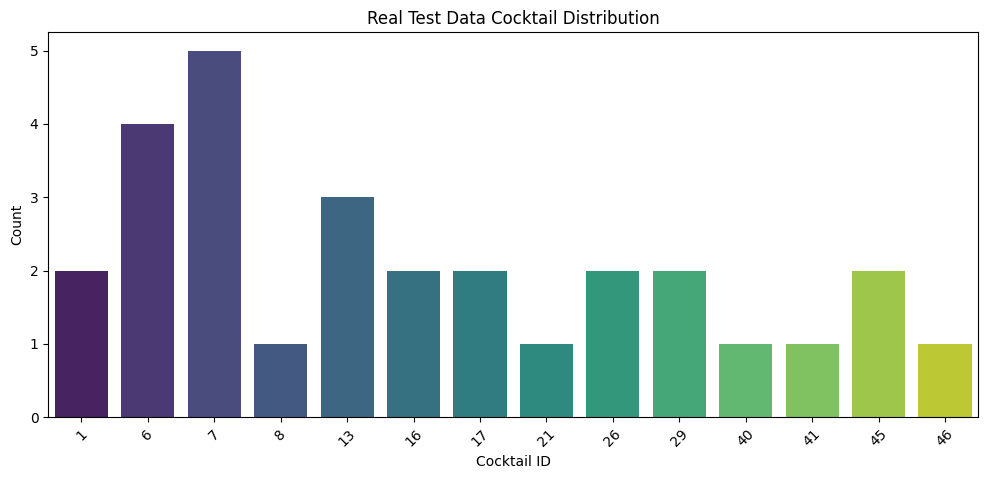

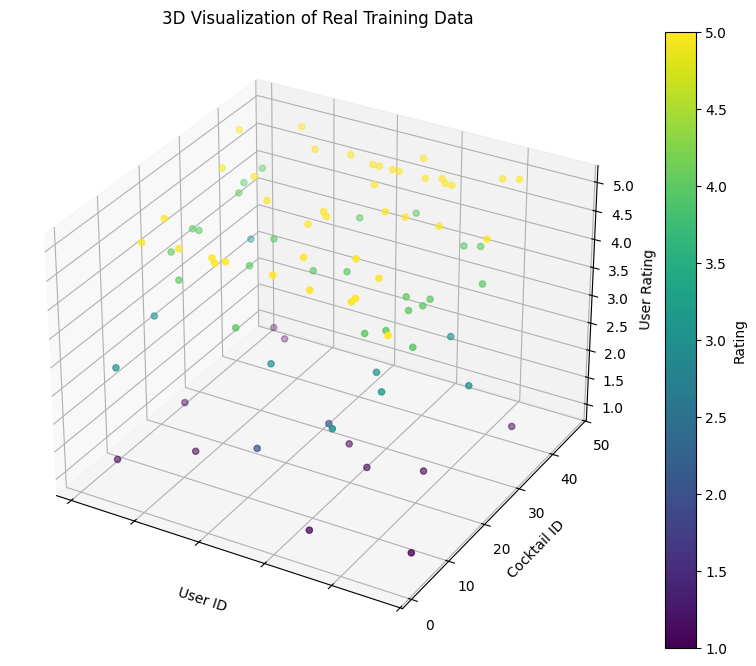

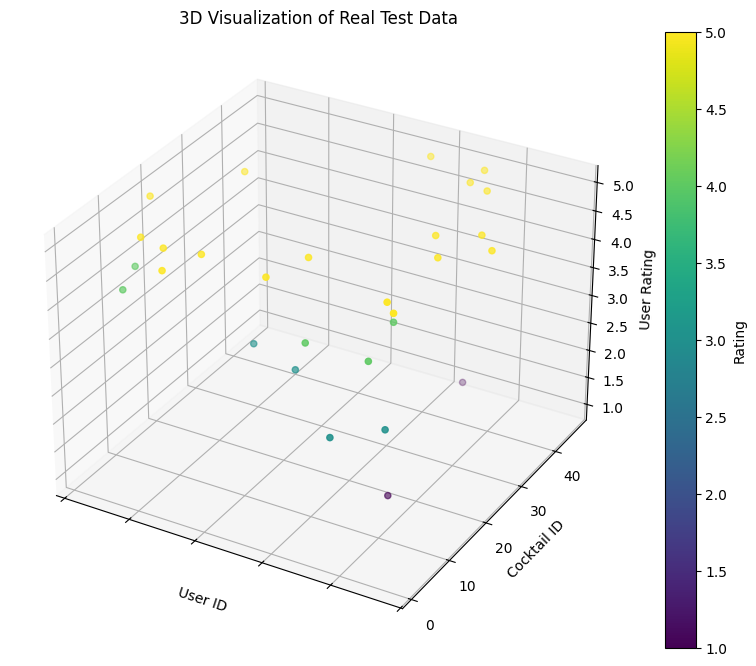

Train RMSE:  [1.3231218236417759, 1.282013051419851, 1.274158431582449, 1.2536818853404188, 1.2131654161743337, 1.1843419009007208, 1.1549587479816652, 1.14553865864908, 1.1250012756250707, 1.1103815434934128, 1.1017173631679862, 1.0620140184440596, 1.0525875528840378, 1.0285312561486493, 1.0060376090722123, 0.982286994961591, 0.9727293533600392, 0.9646562150128315, 0.9390327840551473, 0.9177200501693455]
Test RMSE:  [1.2083826399630786, 1.212468758519111, 1.208231701566567, 1.2114721220428755, 1.2019516811546107, 1.2203753187417665, 1.169778319110645, 1.2109086455674833, 1.2120139735139916, 1.2154150122302338, 1.2321717538536092, 1.2329687112789132, 1.226524821483225, 1.247461907743058, 1.2651336408077418, 1.2463445034156895, 1.2446608811326128, 1.2271669460539603, 1.2807084360910972, 1.2591164909026735]


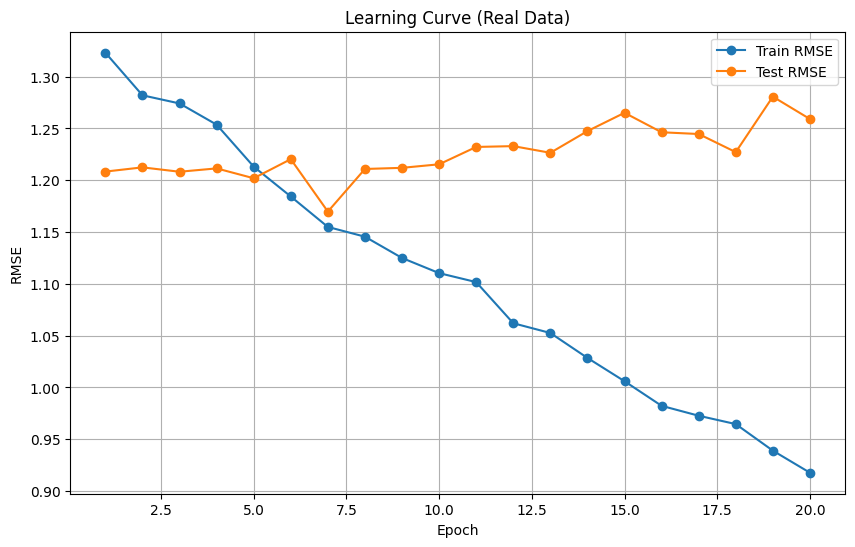

/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/355025600.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


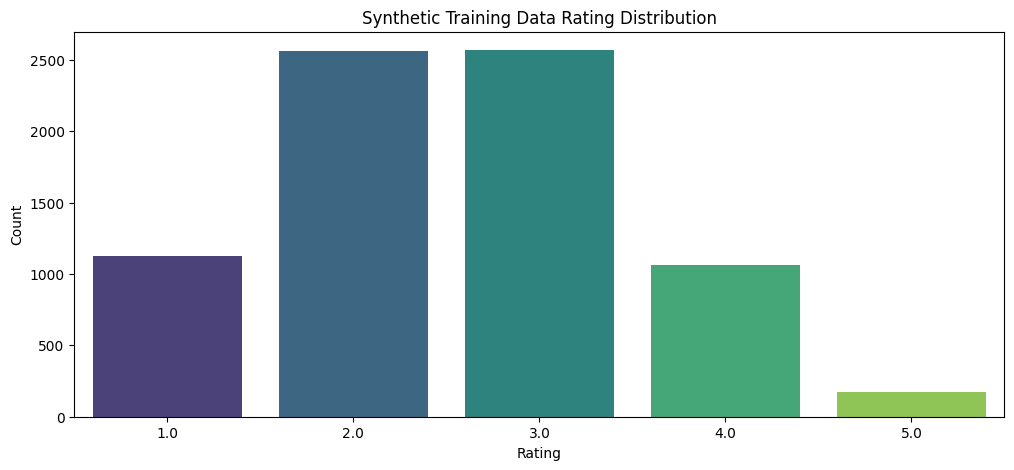

/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/355025600.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


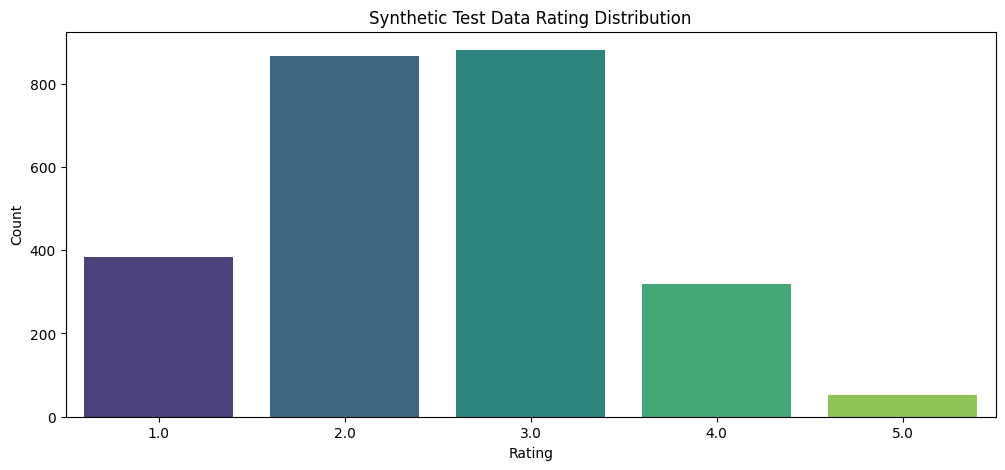

/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/355025600.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cocktail_counts.index, y=cocktail_counts.values, palette='viridis')


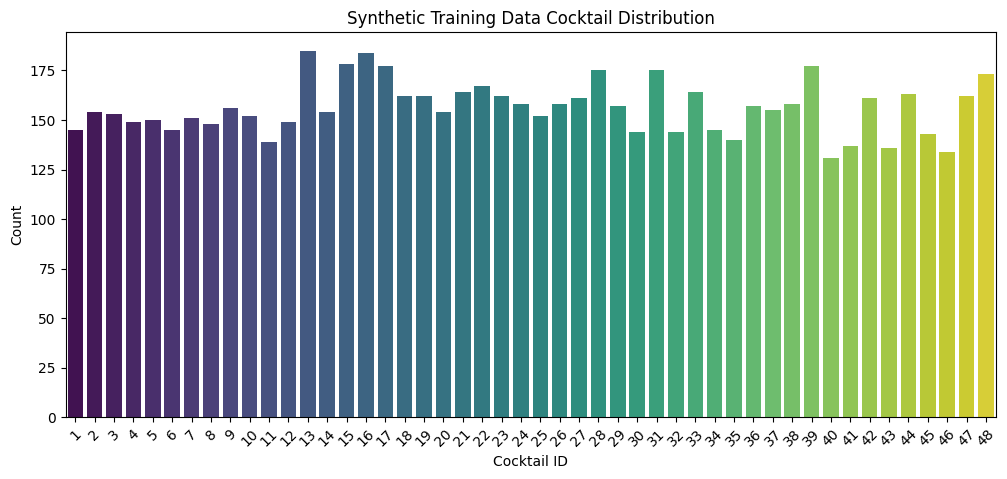

/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/355025600.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cocktail_counts.index, y=cocktail_counts.values, palette='viridis')


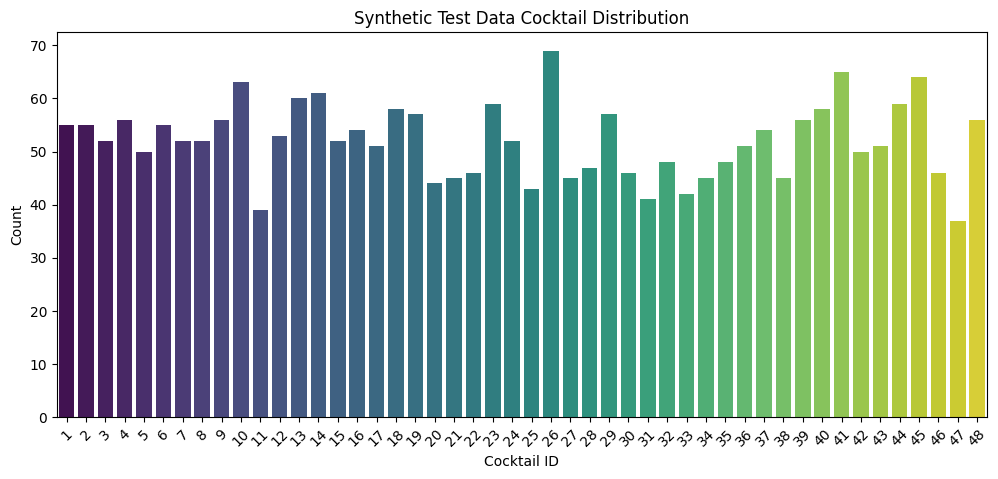

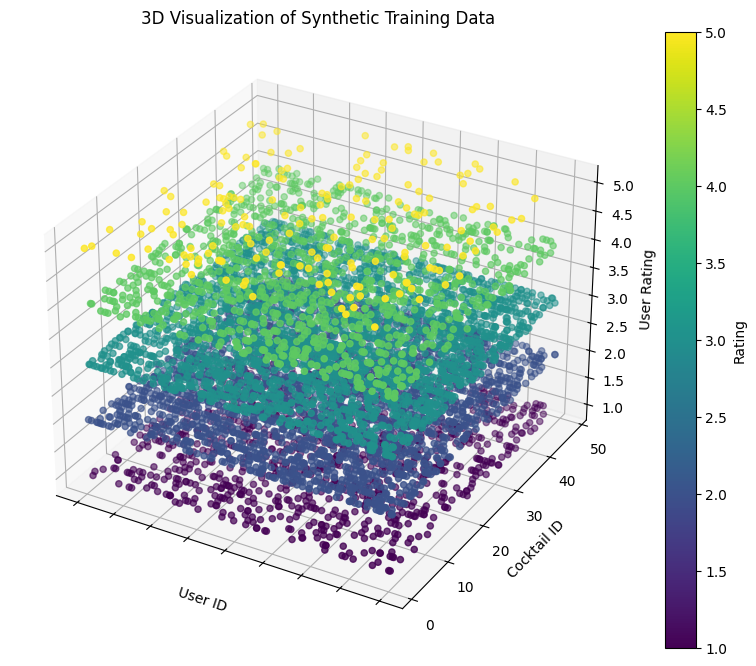

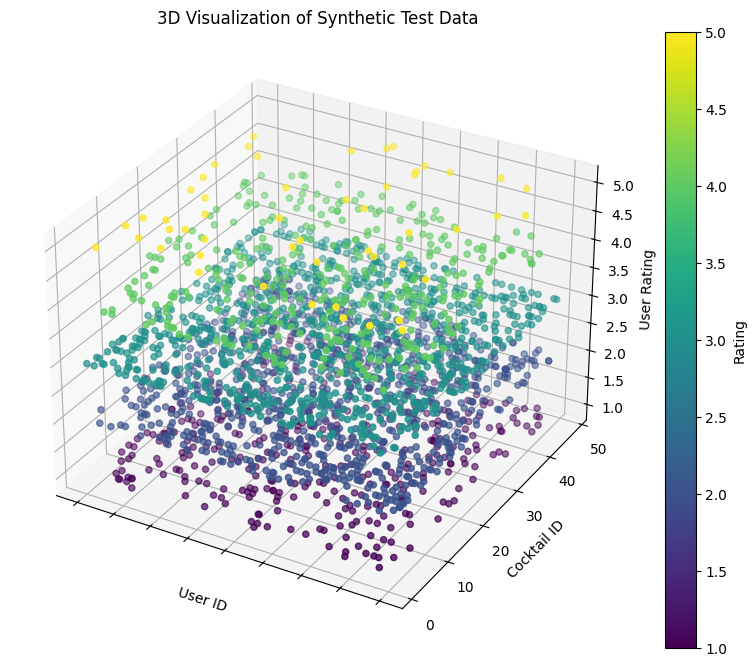

Train RMSE:  [0.9738550295059596, 0.9591692004950835, 0.9457764530597975, 0.9339681310649788, 0.9223309628457792, 0.9097196784446544, 0.8952343717003278, 0.8843674349764671, 0.8726480482777731, 0.859237811674432, 0.8480043431845633, 0.8348574149318189, 0.8206348950882161, 0.8083980542477587, 0.8012350897013918, 0.7814997060325987, 0.7676723807110344, 0.7538979809761723, 0.7420921344762734, 0.7193466670938399]
Test RMSE:  [0.9753141395185904, 0.972906093165022, 0.972067058602937, 0.9762027872440593, 0.9767020567140616, 0.9747038365472723, 0.9751923006916237, 0.9808448962022616, 0.9767268380281888, 0.9803311904433092, 0.9799798389607779, 0.9814244148462156, 0.9820673787030691, 0.9829989341135755, 0.9847676288226941, 0.9866407227908319, 0.9871616641976192, 0.987958134089153, 0.9909681231433003, 0.9956102620972116]


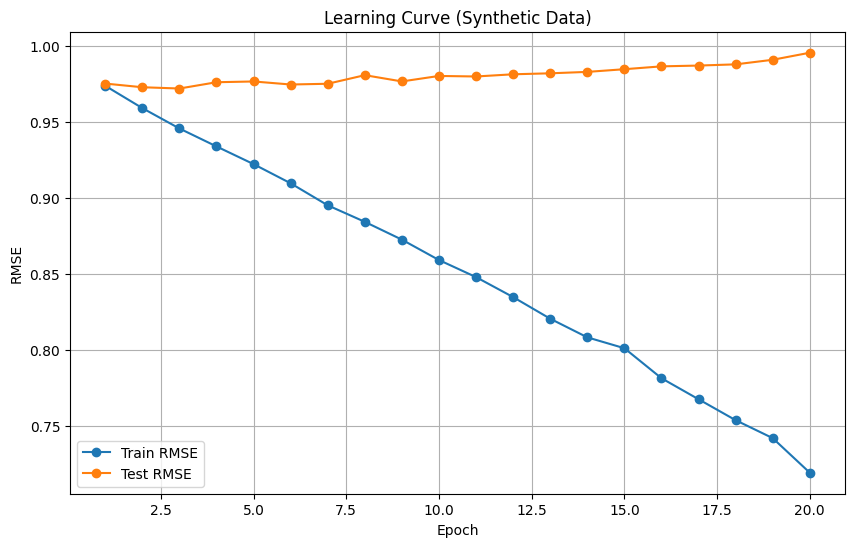

In [38]:
# Merge ratings_df with cocktails_df to include cocktail features
def merge_ratings_with_features(ratings_df, cocktails_df):
    return pd.merge(ratings_df, cocktails_df, on='cocktail_id')

# Function to plot the distribution of ratings
def plot_rating_distribution(df, title):
    plt.figure(figsize=(12, 5))
    rating_counts = df['user_rating'].value_counts().sort_index()
    sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title(title)
    plt.savefig(f'images/{title}_rating_dist.png')
    plt.show()

# Function to plot the distribution of cocktails
def plot_cocktail_distribution(df, title):
    plt.figure(figsize=(12, 5))
    cocktail_counts = df['cocktail_id'].value_counts().sort_index()
    sns.barplot(x=cocktail_counts.index, y=cocktail_counts.values, palette='viridis')
    plt.xlabel('Cocktail ID')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.savefig(f'images/{title}_cocktail_dist.png')
    plt.show()

# Function to calculate RMSE for train and test sets
def calculate_rmse(trainset, testset, n_epochs=20):
    train_rmse = []
    test_rmse = []
    
    for epoch in range(1, n_epochs + 1):
        algo = SVD(n_epochs=epoch)
        algo.fit(trainset)
        
        train_predictions = algo.test(trainset.build_testset())
        test_predictions = algo.test(testset)
        
        train_rmse.append(accuracy.rmse(train_predictions, verbose=False))
        test_rmse.append(accuracy.rmse(test_predictions, verbose=False))


    return train_rmse, test_rmse

# Function to plot 3D data
def plot_3d_data(data, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(data['user_id'].astype(int), data['cocktail_id'].astype(int), data['user_rating'], c=data['user_rating'], cmap='viridis')
    ax.set_xlabel('User ID')
    ax.set_ylabel('Cocktail ID')
    ax.set_zlabel('User Rating')
    ax.set_title(title)
    plt.colorbar(sc, ax=ax, label='Rating')
    
    # Hide x-axis tick labels
    ax.set_xticklabels([])
    
    plt.savefig(f'images/{title}.png')
    plt.show()

# Function to process the dataset and perform analysis
def process_and_analyze(ratings_df, dataset_name):

    # Merge ratings with cocktail features
    merged_df = merge_ratings_with_features(ratings_df, cocktails_df)
    
    # Prepare the data for surprise
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(merged_df[['user_id', 'cocktail_id', 'user_rating']], reader)

    # Train-test split
    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

    # Convert the trainset and testset to DataFrames for plotting
    train_df = pd.DataFrame(trainset.build_testset(), columns=['user_id', 'cocktail_id', 'user_rating'])
    test_df = pd.DataFrame(testset, columns=['user_id', 'cocktail_id', 'user_rating'])

    # Plot the distribution of ratings
    plot_rating_distribution(train_df, f'{dataset_name} Training Data Rating Distribution')
    plot_rating_distribution(test_df, f'{dataset_name} Test Data Rating Distribution')

    plot_cocktail_distribution(train_df, f'{dataset_name} Training Data Cocktail Distribution')
    plot_cocktail_distribution(test_df, f'{dataset_name} Test Data Cocktail Distribution')

    # Plot 3D data
    plot_3d_data(train_df, f'3D Visualization of {dataset_name} Training Data')
    plot_3d_data(test_df, f'3D Visualization of {dataset_name} Test Data')
    
    # Calculate RMSE for 20 epochs
    n_epochs = 20
    train_rmse, test_rmse = calculate_rmse(trainset, testset, n_epochs)

    print("Train RMSE: ", train_rmse)
    print("Test RMSE: ", test_rmse)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_epochs + 1), train_rmse, marker='o', label='Train RMSE')
    plt.plot(range(1, n_epochs + 1), test_rmse, marker='o', label='Test RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curve ({dataset_name} Data)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'images/{dataset_name}_learning_curve.png')
    plt.show()

# Process and analyze real data
process_and_analyze(ratings_df, 'Real')

# Process and analyze synthetic data
process_and_analyze(syn_ratings_df2, 'Synthetic')

### Feature Importance (Permutation Importance)

In [39]:
# Function to calculate permutation feature importance using RandomForestRegressor
def calculate_permutation_importance(ratings_df, cocktails_df, target_column='user_rating', n_repeats=10):
    # Merge ratings with cocktail features
    merged_df = merge_ratings_with_features(ratings_df, cocktails_df)
    # print(merged_df.head())
    
    # Encode categorical features
    le_user = LabelEncoder()
    merged_df['user_id'] = le_user.fit_transform(merged_df['user_id'])
    # le_name = LabelEncoder()
    # merged_df['Name'] = le_name.fit_transform(merged_df['Name'])
    
    # Prepare the features and target
    X = merged_df.drop(columns=[target_column, 'user_email', 'cocktail_name', 'Name', 'user_id', 'cocktail_id'])
    y = merged_df[target_column]
    
    # Train a RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # Calculate permutation importance
    perm_importance = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=42)
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    return feature_importance_df

# Calculate and display feature importance for synthetic data
feature_importance_df = calculate_permutation_importance(syn_ratings_df, cocktails_df)
feature_importance_df.to_csv('images/feature_importance_df.csv')
print(feature_importance_df)

                       Feature  Importance
6                        Sweet    0.000569
55             Juice_Pineapple    0.000374
0                      Alcohol    0.000354
28           Liquor_Green Mint    0.000147
16               Base Wine_Rum    0.000140
..                         ...         ...
44            Liquor Amount_32   -0.000003
47            Liquor Amount_60   -0.000003
13                 Making_Stir   -0.000003
51  Juice_Lime_10/Cranberry_10   -0.000004
82             Soda Amount_200   -0.000008

[117 rows x 2 columns]


### RMSE

In [40]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_rmse(predictions, actuals):
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [41]:
from sklearn.model_selection import train_test_split

# Assuming ratings_df is your full dataset
train_df, test_df = train_test_split(ratings_df, test_size=0.25, random_state=42)

print(f"Training set size: {train_df.shape}")
print(f"Test set size: {test_df.shape}")


Training set size: (86, 3)
Test set size: (29, 3)


In [42]:
def item_based_rmse(train_df, test_df, cocktails_df, num_recommendations):
    user_item_matrix = train_df.pivot_table(index='user_id', columns='cocktail_id', values='user_rating').fillna(0)
    item_similarity = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    predictions = []
    actuals = []

    for user in test_df['user_id'].unique():
        if user in user_item_matrix.index:
            user_ratings = user_item_matrix.loc[user, :]
            user_rated_cocktails = user_ratings[user_ratings > 0].index
            user_recommendations = user_ratings.dot(item_similarity_df) / item_similarity_df.sum(axis=1)
            user_recommendations = user_recommendations.sort_values(ascending=False)

            for cocktail in test_df[test_df['user_id'] == user]['cocktail_id']:
                if cocktail in user_recommendations.index:
                    predictions.append(user_recommendations[cocktail])
                    actuals.append(test_df[(test_df['user_id'] == user) & (test_df['cocktail_id'] == cocktail)]['user_rating'].values[0])
    
    return calculate_rmse(predictions, actuals)

# Example usage:
item_based_rmse_value = item_based_rmse(train_df, test_df, cocktails_df, num_recommendations)
print(f"Item-Based RMSE: {item_based_rmse_value}")


Item-Based RMSE: 3.8637250605321287


In [43]:
def user_based_rmse(train_df, test_df, cocktails_df, num_neighbors, num_recommendations):
    user_item_matrix = train_df.pivot_table(index='user_id', columns='cocktail_id', values='user_rating').fillna(0)
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

    predictions = []
    actuals = []

    for user in test_df['user_id'].unique():
        if user in user_similarity_df.index:
            user_similarities = user_similarity_df.loc[user, :]
            similar_users = user_similarities.sort_values(ascending=False).index[1:num_neighbors+1]
            similar_users_ratings = user_item_matrix.loc[similar_users, :]
            user_recommendations = similar_users_ratings.T.dot(user_similarities[similar_users]) / user_similarities[similar_users].sum()
            user_recommendations = user_recommendations.sort_values(ascending=False)

            for cocktail in test_df[test_df['user_id'] == user]['cocktail_id']:
                if cocktail in user_recommendations.index:
                    predictions.append(user_recommendations[cocktail])
                    actuals.append(test_df[(test_df['user_id'] == user) & (test_df['cocktail_id'] == cocktail)]['user_rating'].values[0])
    
    return calculate_rmse(predictions, actuals)

# Example usage:
user_based_rmse_value = user_based_rmse(train_df, test_df, cocktails_df, num_neighbors, num_recommendations)
print(f"User-Based RMSE: {user_based_rmse_value}")


User-Based RMSE: 3.8263379029089486


In [44]:
def content_based_rmse(train_df, test_df, cocktails_df, num_recommendations):
    cocktail_features = cocktails_df.apply(lambda x: ' '.join(x.astype(str)), axis=1)
    vectorizer = CountVectorizer().fit_transform(cocktail_features)
    cocktail_vectors = vectorizer.toarray()
    content_similarity = cosine_similarity(cocktail_vectors)
    content_similarity_df = pd.DataFrame(content_similarity, index=cocktails_df['cocktail_id'], columns=cocktails_df['cocktail_id'])

    predictions = []
    actuals = []

    user_item_matrix = train_df.pivot_table(index='user_id', columns='cocktail_id', values='user_rating').fillna(0)
    for user in test_df['user_id'].unique():
        if user in user_item_matrix.index:
            user_ratings = user_item_matrix.loc[user, :]
            user_rated_cocktails = user_ratings[user_ratings > 0].index
            user_recommendations = pd.Series(dtype='float64')

            for cocktail in user_rated_cocktails:
                similar_cocktails = content_similarity_df[cocktail].sort_values(ascending=False).iloc[1:num_recommendations+1]
                similar_cocktails = pd.Series(similar_cocktails.index)
                if not similar_cocktails.empty:
                    user_recommendations = pd.concat([user_recommendations, similar_cocktails])
            user_recommendations = user_recommendations.value_counts().sort_values(ascending=False)

            for cocktail in test_df[test_df['user_id'] == user]['cocktail_id']:
                if cocktail in user_recommendations.index:
                    predictions.append(user_recommendations[cocktail])
                    actuals.append(test_df[(test_df['user_id'] == user) & (test_df['cocktail_id'] == cocktail)]['user_rating'].values[0])
    
    return calculate_rmse(predictions, actuals)

# Example usage:
content_based_rmse_value = content_based_rmse(train_df, test_df, cocktails_df, num_recommendations)
print(f"Content-Based RMSE: {content_based_rmse_value}")


Content-Based RMSE: 2.958039891549808


/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/2165362214.py:22: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  user_recommendations = pd.concat([user_recommendations, similar_cocktails])
/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/2165362214.py:22: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  user_recommendations = pd.concat([user_recommendations, similar_cocktails])
/var/folders/z9/y1zmbc2500578321lpfyjq1r0000gn/T/ipykernel_10467/2165362214.py:22: FutureWarning: The behavior of array concatenation with empty entri

In [45]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

def svd_rmse(train_df, test_df):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(train_df[['user_id', 'cocktail_id', 'user_rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)
    algo = SVD()
    algo.fit(trainset)

    test_predictions = algo.test(testset)
    test_rmse = accuracy.rmse(test_predictions)
    return test_rmse

# Example usage:
svd_rmse_value = svd_rmse(train_df, test_df)
print(f"SVD RMSE: {svd_rmse_value}")


RMSE: 1.1279
SVD RMSE: 1.127928543187012


In [46]:
print(f"Item-Based RMSE: {item_based_rmse_value}")
print(f"User-Based RMSE: {user_based_rmse_value}")
print(f"Content-Based RMSE: {content_based_rmse_value}")
print(f"SVD RMSE: {svd_rmse_value}")


Item-Based RMSE: 3.8637250605321287
User-Based RMSE: 3.8263379029089486
Content-Based RMSE: 2.958039891549808
SVD RMSE: 1.127928543187012
